In [223]:
import pandas as pd
from google.cloud import bigquery;
from google.cloud.bigquery import dbapi;
%load_ext google.cloud.bigquery
from google.cloud import bigquery
from pdf2image import convert_from_path
from IPython.display import Image, display
# client=bigquery.Client()
client = bigquery.Client("som-nero-phi-jonc101")

The google.cloud.bigquery extension is already loaded. To reload it, use:
  %reload_ext google.cloud.bigquery


/Users/wenyuanchen/anaconda3/lib/python3.11/site-packages/google/auth/_default.py:76: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


# Some utility functions

In [3]:
def find_unique_orders(df, return_combinations=False,):
    """
    Find the number of unique combinations of specific columns in a DataFrame.

    Parameters:
        df (pd.DataFrame): The input DataFrame.
        return_combinations (bool): If True, return the unique combinations as a DataFrame.
                                   If False, return only the count of unique combinations.

    Returns:
        int or pd.DataFrame: The number of unique combinations or a DataFrame of unique combinations.
    """
    # Drop duplicates based on the specified columns
    subset = ['anon_id', 'pat_enc_csn_id_coded', 'order_proc_id_coded', 'order_time_jittered_utc']
    unique_combinations = df.drop_duplicates(subset=subset)
    
    # Count the number of unique combinations
    num_unique_combinations = len(unique_combinations)
    
    # Return the result based on the return_combinations flag
    if return_combinations:
        return unique_combinations
    else:
        return num_unique_combinations

In [4]:
# Define a function to find antibiotic matches in the medication name
def find_antibiotics(med_name, antibiotic_list):
    if pd.isna(med_name):
        return None
    matches = [j for j in antibiotic_list if j.lower() in med_name.lower()]
    return matches if matches else "No Match"


In [ ]:
# clean_antibiotic.csv is downloaded from the following URL: https://docs.google.com/spreadsheets/d/1NUBXLbMZ4n3A0-b-waVQGTOmcFSi0rSp/edit?gid=1568991887#gid=1568991887 
clean_antibiotic = pd.read_csv("clean_antibiotic.csv") # the top 50 is the same as prior_antibiotics_list in bigquery
antibiotic_list = clean_antibiotic["antibiotic_name"]


# Previous Flowchart: some steps are off

<img src="Aim_4_Cohort_Flowchart_previous/Aim_4_Cohort_Flowchart_previous.001.png" alt="Previous Adult ED Flowchart" width="500">

# Current Flowchart with updated steps and logic
## We will walk through step by step

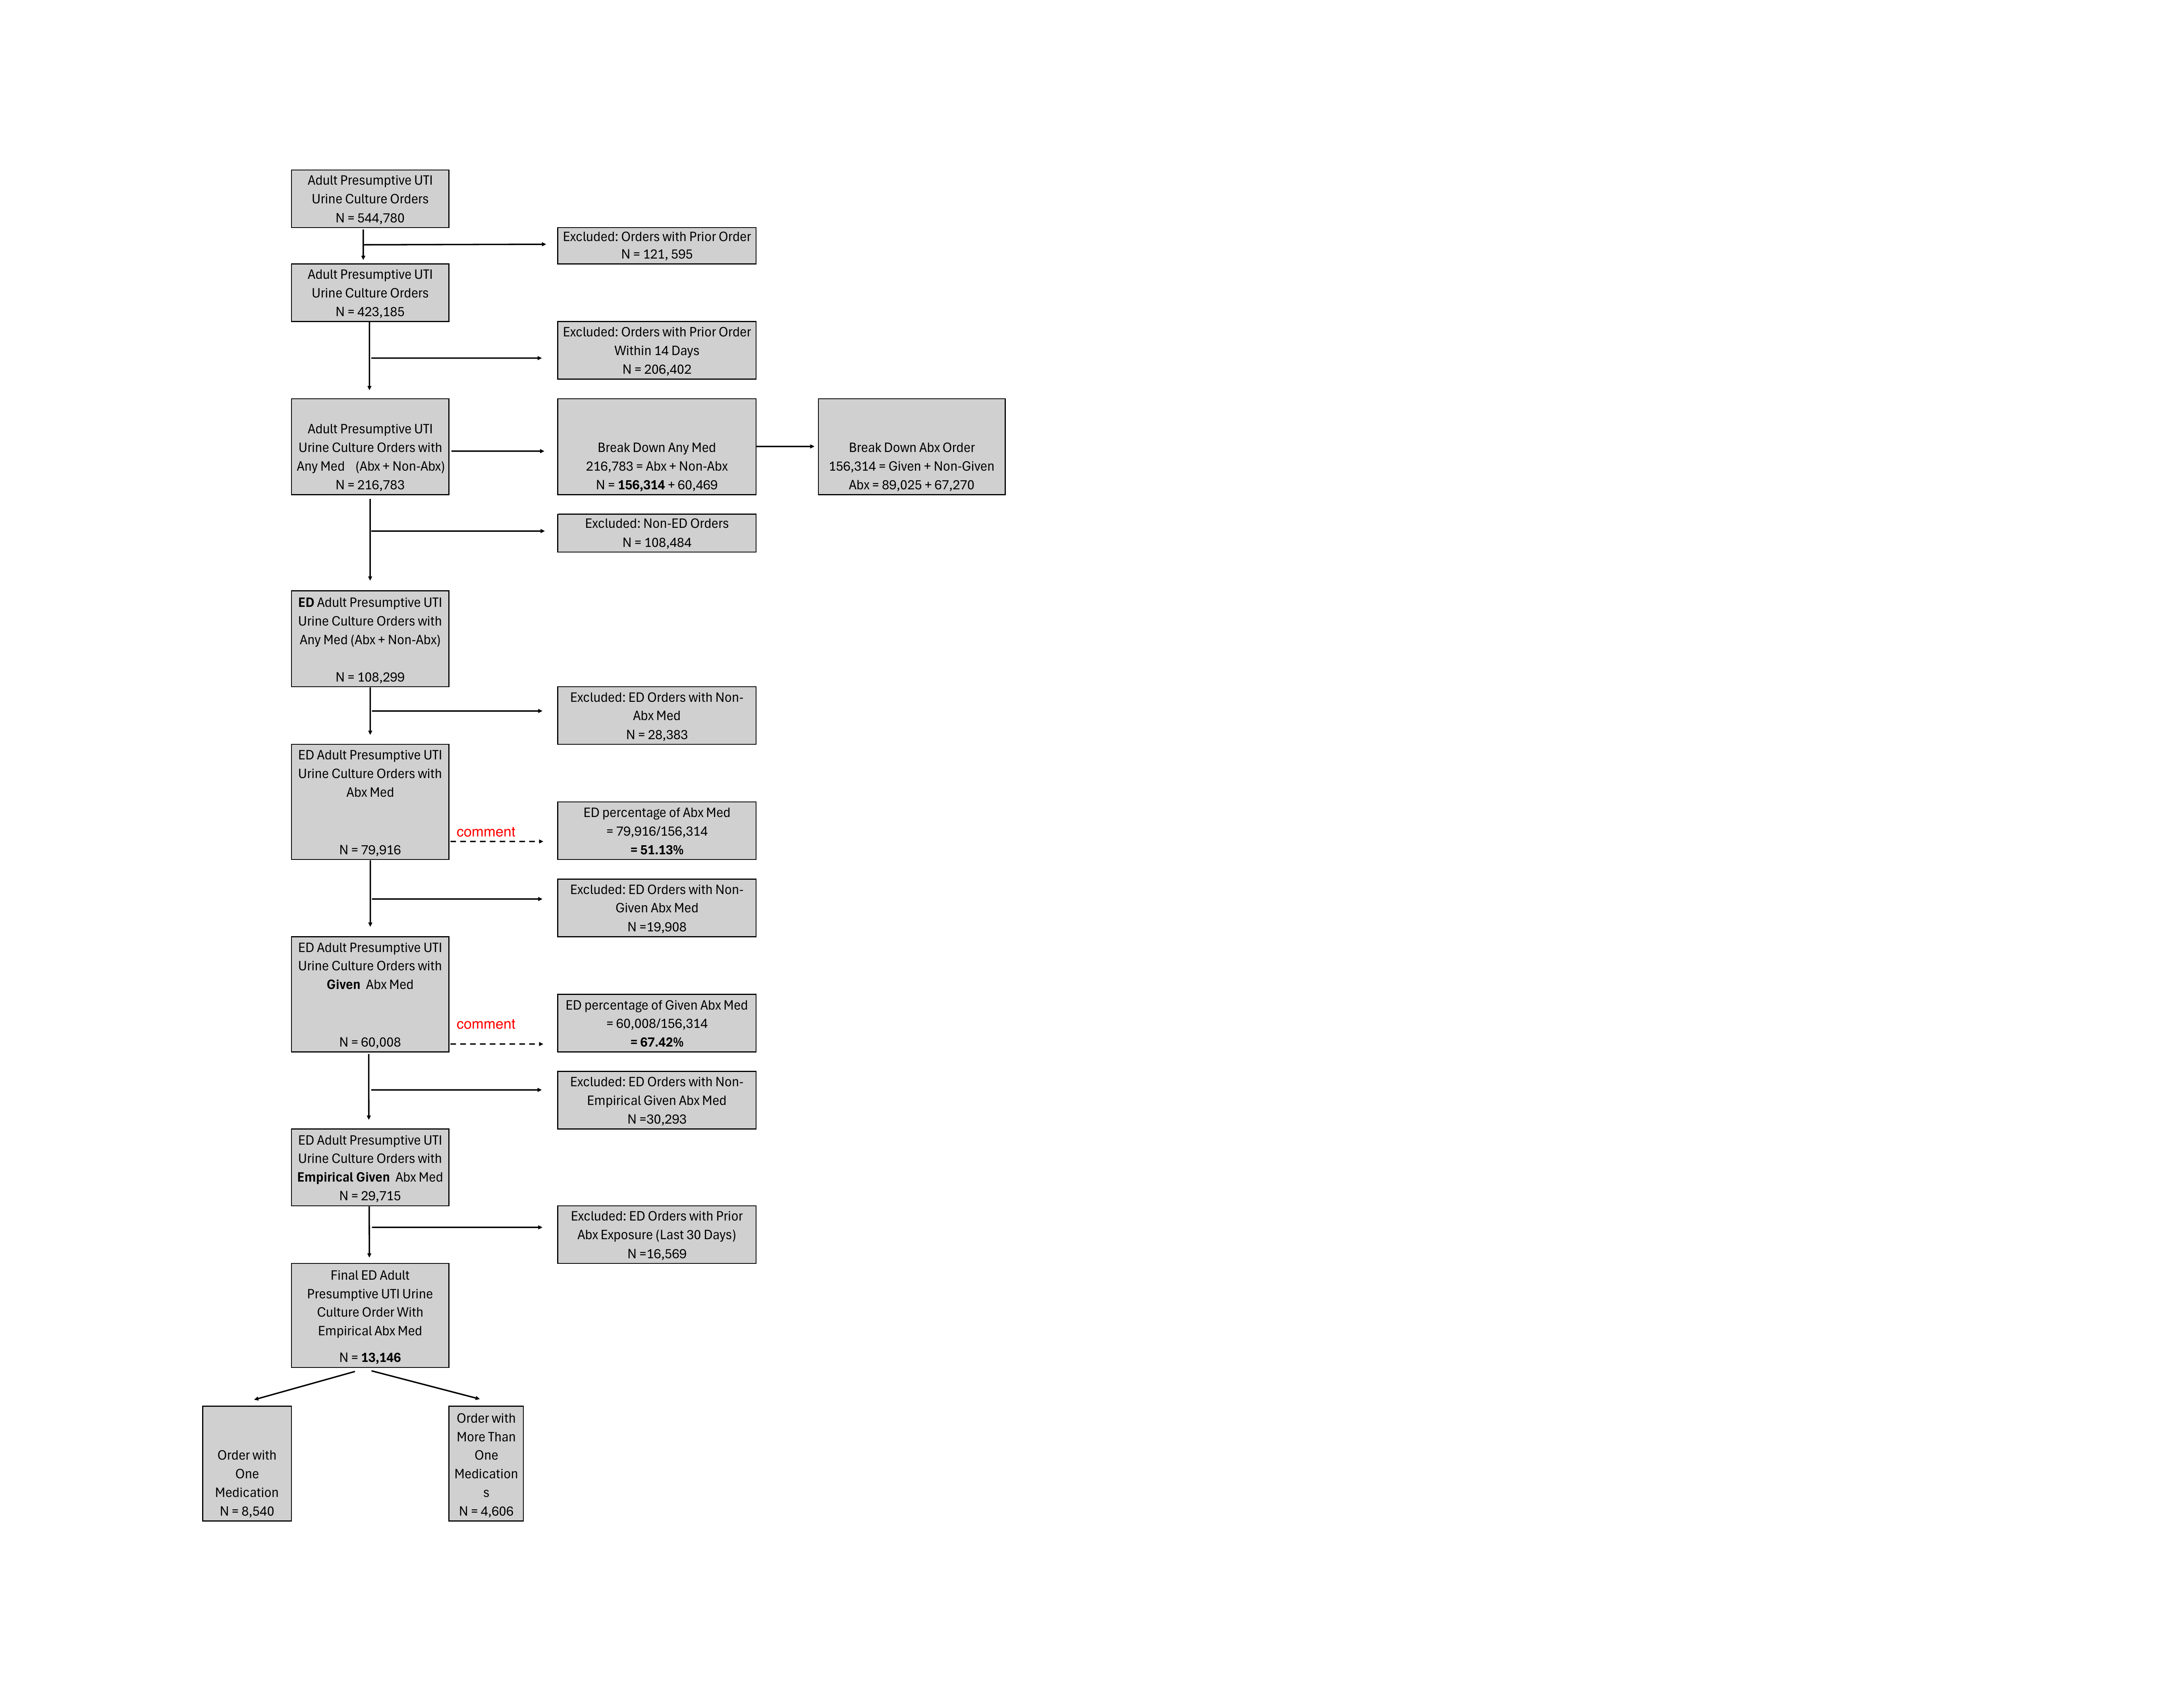

In [245]:
# Convert the first page of the PDF
pages = convert_from_path('Notebook/imgs/Aim_4_Flowchart_Custom.pdf', dpi=500)
path_png = 'Notebook/imgs/oervall.png'
pages[0].save(path_png, 'PNG')
# Display the image in the notebook
display(Image(filename=path_png))

# ----------------------**Step 1** ------------------------

### Refactor Fateme's code for urine culture only
Reference: https://github.com/HealthRex/CDSS/blob/master/scripts/antibiotic-susceptibility/sql/queries/microbiology_cultures_cohort_query.sql

In [6]:
%%bigquery --use_rest_api all_urine_cohort
-- This query is the main query for creating a table named microbiology_cultures_cohort that forms the basis of the microbiology cultures cohort. 
-- The table is generated through a series of steps, each designed to filter and enrich the dataset. 
-- Once the main cohort table is created, additional features will be added to this table to complete the dataset for analysis.


######################################################################################## 
-- Create or replace the cohort table named microbiology_urine_cultures_cohort
######################################################################################## 


-- Step 1: Extract microbiology cultures for specific types (URINE)
WITH microbiology_cultures AS (
    SELECT DISTINCT
        op.anon_id, 
        op.pat_enc_csn_id_coded, 
        op.order_proc_id_coded, 
        op.order_time_jittered_utc, 
        op.ordering_mode,
        lr.result_time_jittered_utc, # added the result time too
        CASE 
            WHEN op.description LIKE '%URINE%' THEN 'URINE'
            ELSE 'OTHER' 
        END AS culture_description  -- Capture the culture type
    FROM 
        `som-nero-phi-jonc101.shc_core_2023.order_proc` op
    INNER JOIN
        `som-nero-phi-jonc101.shc_core_2023.lab_result` lr
    ON
        op.order_proc_id_coded = lr.order_id_coded
    WHERE
        op.order_type LIKE "Microbiology%"
        AND (op.description LIKE "%URINE%")
) # Only keep urine culture
select * from microbiology_cultures

Query is running:   0%|          |

Downloading:   0%|          |

In [7]:
print("the unique order number for all urine culture is {}".format(find_unique_orders(all_urine_cohort)))

the unique order number for urine only culture is 544780


# -----------------------**Step 2** ----------------------

In [8]:
%%bigquery --use_rest_api starting_cohort
-- This query is the main query for creating a table named microbiology_cultures_cohort that forms the basis of the microbiology cultures cohort. 
-- The table is generated through a series of steps, each designed to filter and enrich the dataset. 
-- Once the main cohort table is created, additional features will be added to this table to complete the dataset for analysis.


######################################################################################## 
-- Create or replace the cohort table named microbiology_urine_cultures_cohort
######################################################################################## 


-- Step 1: Extract microbiology cultures for specific types (URINE)
WITH microbiology_cultures AS (
    SELECT DISTINCT
        op.anon_id, 
        op.pat_enc_csn_id_coded, 
        op.order_proc_id_coded, 
        op.order_time_jittered_utc, 
        op.ordering_mode,
        lr.result_time_jittered_utc, # added the result time too
        CASE 
            WHEN op.description LIKE '%URINE%' THEN 'URINE'
            ELSE 'OTHER' 
        END AS culture_description  -- Capture the culture type
    FROM 
        `som-nero-phi-jonc101.shc_core_2023.order_proc` op
    INNER JOIN
        `som-nero-phi-jonc101.shc_core_2023.lab_result` lr
    ON
        op.order_proc_id_coded = lr.order_id_coded
    WHERE
        op.order_type LIKE "Microbiology%"
        AND (op.description LIKE "%URINE%")
), # Only keep urine culture


######################################################################################## 
-- Step 2: Filter for adult patients only
########################################################################################    

adult_microbiology_cultures AS (
    SELECT 
        mc.anon_id, 
        mc.pat_enc_csn_id_coded, 
        mc.order_proc_id_coded, 
        mc.order_time_jittered_utc, 
        mc.ordering_mode,
        mc.culture_description, -- Include culture_description here
        mc.result_time_jittered_utc

    FROM 
        microbiology_cultures mc
    INNER JOIN
        `som-nero-phi-jonc101.shc_core_2023.demographic` demo
    USING
        (anon_id)
    WHERE
        DATE_DIFF(CAST(mc.order_time_jittered_utc as DATE), demo.BIRTH_DATE_JITTERED, YEAR) >= 18
),

    
######################################################################################## 
-- Step 3: Identify culture orders within the prior two weeks
########################################################################################     
    
order_in_prior_two_weeks AS (
    SELECT DISTINCT
         auc.order_proc_id_coded
    FROM 
        `som-nero-phi-jonc101.shc_core_2023.order_proc` op
    INNER JOIN
        `som-nero-phi-jonc101.shc_core_2023.lab_result` lr
    ON
        op.order_proc_id_coded = lr.order_id_coded
    INNER JOIN
        adult_microbiology_cultures auc 
    ON
        op.anon_id = auc.anon_id
    WHERE
        op.order_type LIKE "Microbiology%"
        AND (op.description LIKE "%URINE%")
        AND auc.order_time_jittered_utc > op.order_time_jittered_utc
        AND TIMESTAMP_DIFF(auc.order_time_jittered_utc, op.order_time_jittered_utc, DAY) < 14
),

    
######################################################################################## 
-- Step 4: Exclude cultures with a prior culture order in the last two weeks
########################################################################################       

included_microbiology_cultures AS (
    SELECT DISTINCT
        amc.*
    FROM 
        adult_microbiology_cultures amc
    WHERE 
        amc.order_proc_id_coded NOT IN (SELECT order_proc_id_coded FROM order_in_prior_two_weeks)
),

###########################################################################################################
-- Step 5: Flag cultures as positive if they have corresponding entries in the culture_sensitivity table
###########################################################################################################    

all_cultures_with_flag AS (
    SELECT 
        imc.anon_id, 
        imc.pat_enc_csn_id_coded, 
        imc.order_proc_id_coded, 
        imc.order_time_jittered_utc, 
        imc.result_time_jittered_utc,
        imc.ordering_mode,
        imc.culture_description,
        IF(cs.order_proc_id_coded IS NOT NULL, 1, 0) AS was_positive
    FROM 
        included_microbiology_cultures imc
    LEFT JOIN 
        (SELECT DISTINCT order_proc_id_coded FROM `som-nero-phi-jonc101.shc_core_2023.culture_sensitivity`) cs
    ON 
        imc.order_proc_id_coded = cs.order_proc_id_coded
),


#########################################################################################################################
-- Step 6: Get detailed information for positive cultures, clean antibiotic names, and exclude non-antibiotic entries
#########################################################################################################################     
positive_culture_details AS (
    SELECT 
        cs.order_proc_id_coded,
        cs.organism,
        -- Clean and standardize the antibiotic name using the updated cleaning approach
        INITCAP(TRIM(
          REGEXP_REPLACE(
          REGEXP_REPLACE(
          REGEXP_REPLACE(
          REGEXP_REPLACE(
            REGEXP_REPLACE(
                REGEXP_REPLACE(
                    LOWER(cs.antibiotic),
                    'penicillin[^a-z].*$', 'penicillin'
                ),
                '^[^a-z]*|\\s+\\S*[^a-z\\s]+.*$|\\.+$', ''
            ),
              '\\s*\\d+(\\.\\d+)?\\s*(mg|mcg|gram|ml|%)', ''  -- Remove dosages or concentrations
          ),
          '\\(.*?\\)', ''  -- Remove text in parentheses
        ),' in.*$|tablet|capsule|intravenous|piggyback|' ||
                            'solution|suspension|oral|sodium|chloride|' ||
                            'injection|citrate|soln|dextrose|iv|' ||
                            'macrocrystals|macrocrystal|axetil|potassium|packet|' ||
                            'monohydrate|ethylsuccinate|powder|mandelate|' ||
                            'hyclate|hcl|hippurate|tromethamine|' ||
                            'million|unit|syrup|chewable|delayed|mphase|' ||
                            'release|benzathine|syringe|dispersible|' ||
                            'sulfate|procaine|blue|hyos|sod*phos|' ||
                            'susp|and|fosamil|extended|succinate|granules|' ||
                            'delay|pot|ext|rel|cyam|salicylate|salicyl|' ||
                            'sodphos|methylene|stearate|synergy', ''                   
        ),
        '\\d|\\sfor\\s*|/ml\\s*|\\sml\\s*|\\-+\\s*|\\,+\\s*',''
        )
        )
      )  AS antibiotic,
        cs.suscept AS susceptibility
    FROM 
        som-nero-phi-jonc101.shc_core_2023.culture_sensitivity cs
    INNER JOIN (
        -- Subquery to get antibiotic counts for those with more than 10 occurrences
        SELECT 
          INITCAP(TRIM(
          REGEXP_REPLACE(
          REGEXP_REPLACE(
          REGEXP_REPLACE(
          REGEXP_REPLACE(
            REGEXP_REPLACE(
                REGEXP_REPLACE(
                    LOWER(antibiotic),
                    'penicillin[^a-z].*$', 'penicillin'
                ),
                '^[^a-z]*|\\s+\\S*[^a-z\\s]+.*$|\\.+$', ''
            ),
              '\\s*\\d+(\\.\\d+)?\\s*(mg|mcg|gram|ml|%)', ''  -- Remove dosages or concentrations
          ),
          '\\(.*?\\)', ''  -- Remove text in parentheses
        ),' in.*$|tablet|capsule|intravenous|piggyback|' ||
                            'solution|suspension|oral|sodium|chloride|' ||
                            'injection|citrate|soln|dextrose|iv|' ||
                            'macrocrystals|macrocrystal|axetil|potassium|packet|' ||
                            'monohydrate|ethylsuccinate|powder|mandelate|' ||
                            'hyclate|hcl|hippurate|tromethamine|' ||
                            'million|unit|syrup|chewable|delayed|mphase|' ||
                            'release|benzathine|syringe|dispersible|' ||
                            'sulfate|procaine|blue|hyos|sod*phos|' ||
                            'susp|and|fosamil|extended|succinate|granules|' ||
                            'delay|pot|ext|rel|cyam|salicylate|salicyl|' ||
                            'sodphos|methylene|stearate|synergy', ''                   
        ),
        '\\d|\\sfor\\s*|/ml\\s*|\\sml\\s*|\\-+\\s*|\\,+\\s*',''
        )
        )
      )AS cleaned_antibiotic,
            COUNT(*) AS count
        FROM 
            som-nero-phi-jonc101.shc_core_2023.culture_sensitivity
        GROUP BY 
            cleaned_antibiotic
        HAVING 
            COUNT(*) >= 10  -- Include only antibiotics that appear 10 times or more
    ) AS antibiotic_counts 
    ON 


      INITCAP(TRIM(
          REGEXP_REPLACE(
          REGEXP_REPLACE(
          REGEXP_REPLACE(
          REGEXP_REPLACE(
            REGEXP_REPLACE(
                REGEXP_REPLACE(
                    LOWER(cs.antibiotic),
                    'penicillin[^a-z].*$', 'penicillin'
                ),
                '^[^a-z]*|\\s+\\S*[^a-z\\s]+.*$|\\.+$', ''
            ),
              '\\s*\\d+(\\.\\d+)?\\s*(mg|mcg|gram|ml|%)', ''  -- Remove dosages or concentrations
          ),
          '\\(.*?\\)', ''  -- Remove text in parentheses
        ),' in.*$|tablet|capsule|intravenous|piggyback|' ||
                            'solution|suspension|oral|sodium|chloride|' ||
                            'injection|citrate|soln|dextrose|iv|' ||
                            'macrocrystals|macrocrystal|axetil|potassium|packet|' ||
                            'monohydrate|ethylsuccinate|powder|mandelate|' ||
                            'hyclate|hcl|hippurate|tromethamine|' ||
                            'million|unit|syrup|chewable|delayed|mphase|' ||
                            'release|benzathine|syringe|dispersible|' ||
                            'sulfate|procaine|blue|hyos|sod*phos|' ||
                            'susp|and|fosamil|extended|succinate|granules|' ||
                            'delay|pot|ext|rel|cyam|salicylate|salicyl|' ||
                            'sodphos|methylene|stearate|synergy', ''                   
        ),
        '\\d|\\sfor\\s*|/ml\\s*|\\sml\\s*|\\-+\\s*|\\,+\\s*',''
        )
        )
      )= antibiotic_counts.cleaned_antibiotic
    WHERE
        NOT (
            cs.antibiotic LIKE '%InBasket%'  
            OR cs.antibiotic LIKE '%Beta Lactamase%'  
            OR cs.antibiotic LIKE '%BlaZ PCR%'  
            OR cs.antibiotic LIKE '%Carbapenemase%'  
            OR cs.antibiotic LIKE '%D-Test%'  
            OR cs.antibiotic LIKE '%Esbl%'  
            OR cs.antibiotic LIKE '%ermPCR%'  
            OR cs.antibiotic LIKE '%Mupirocin%'  
            OR cs.antibiotic LIKE '%IMP%'  
            OR cs.antibiotic LIKE '%Inducible Clindamycin%'  
            OR cs.antibiotic LIKE '%INTERNAL CONTROL%'  
            OR cs.antibiotic LIKE '%KPC%'  
            OR cs.antibiotic LIKE '%MecA PCR%'  
            OR cs.antibiotic LIKE '%NDM%'  
            OR cs.antibiotic LIKE '%Ox Plate Screen%'  
            OR cs.antibiotic LIKE '%OXA-48-LIKE%'  
            OR cs.antibiotic LIKE '%VIM%'  
            OR cs.antibiotic LIKE '%Method%'  
            OR cs.antibiotic LIKE '%INH%'   
            OR cs.antibiotic LIKE '%Polymyxin B%' 
            OR cs.antibiotic LIKE '%Nalidixic%'   
            OR cs.antibiotic LIKE '%Flucytosine%' 
            OR cs.antibiotic LIKE '%Rifampin%' 
            OR cs.antibiotic LIKE '%Ethambutol%' 
            OR cs.antibiotic LIKE '%Pyrazinamide%' 
            OR cs.antibiotic LIKE '%Clofazimine%' 
            OR cs.antibiotic LIKE '%Rifabutin%' 
            OR cs.antibiotic IN ('Posaconazole','Penicillin/Ampicillin','Omadacycline', 'Amphotericin B', 'Polymixin B', 'Fluconazole', 'Itraconazole', 'Caspofungin', 'Voriconazole', 'Anidulafungin', 'Micafungin', 'Isavuconazole', 'Antibiotic', 'OXA48-LIKE PCR', 'ESBL confirmation test', 'Oxacillin Screen')
        )
)

#########################################################################################################################
  -- Step 7: Final selection of required fields
#########################################################################################################################   

SELECT 
    acwf.anon_id,
    acwf.pat_enc_csn_id_coded,
    acwf.order_proc_id_coded,
    acwf.order_time_jittered_utc,
    acwf.result_time_jittered_utc,
    acwf.ordering_mode,
    acwf.culture_description,
    acwf.was_positive,
    pcd.organism,
    pcd.antibiotic,
    CASE
        WHEN pcd.susceptibility IS NULL THEN NULL  -- Keep NULL values unchanged
        WHEN pcd.susceptibility IN ('Susceptible', 'Not Detected', 'Negative' ) THEN 'Susceptible'
        WHEN pcd.susceptibility IN ('Resistant', 'Non Susceptible', 'Positive', 'Detected') THEN 'Resistant'
        WHEN pcd.susceptibility IN ('Intermediate', 'Susceptible - Dose Dependent') THEN 'Intermediate'
        WHEN pcd.susceptibility IN ('No Interpretation', 'Not done', 'Inconclusive', 'See Comment') THEN 'Inconclusive'
        WHEN pcd.susceptibility IN ('Synergy', 'No Synergy') THEN 'Synergism'
        ELSE 'Unknown'  -- Mark unexpected values as Unknown
    END AS susceptibility
FROM
    all_cultures_with_flag acwf
LEFT JOIN
    positive_culture_details pcd
ON
    acwf.order_proc_id_coded = pcd.order_proc_id_coded
WHERE
    -- Exclude rows where susceptibility would be 'Unknown'
    (pcd.susceptibility IS NULL OR
    pcd.susceptibility IN ('Susceptible', 'Positive', 'Detected',
                           'Resistant', 'Non Susceptible', 'Negative',
                           'Intermediate', 'Susceptible - Dose Dependent',
                           'No Interpretation', 'Not done', 'Inconclusive', 'See Comment',
                           'Synergy', 'No Synergy', 'Not Detected'));


Query is running:   0%|          |

Downloading:   0%|          |

In [11]:
print("the unique order number for urine only starting culture after 2 week exclusion is {}".format(find_unique_orders(starting_cohort)))

the unique order number for urine only starting culture after 2 week exclusion is 423185


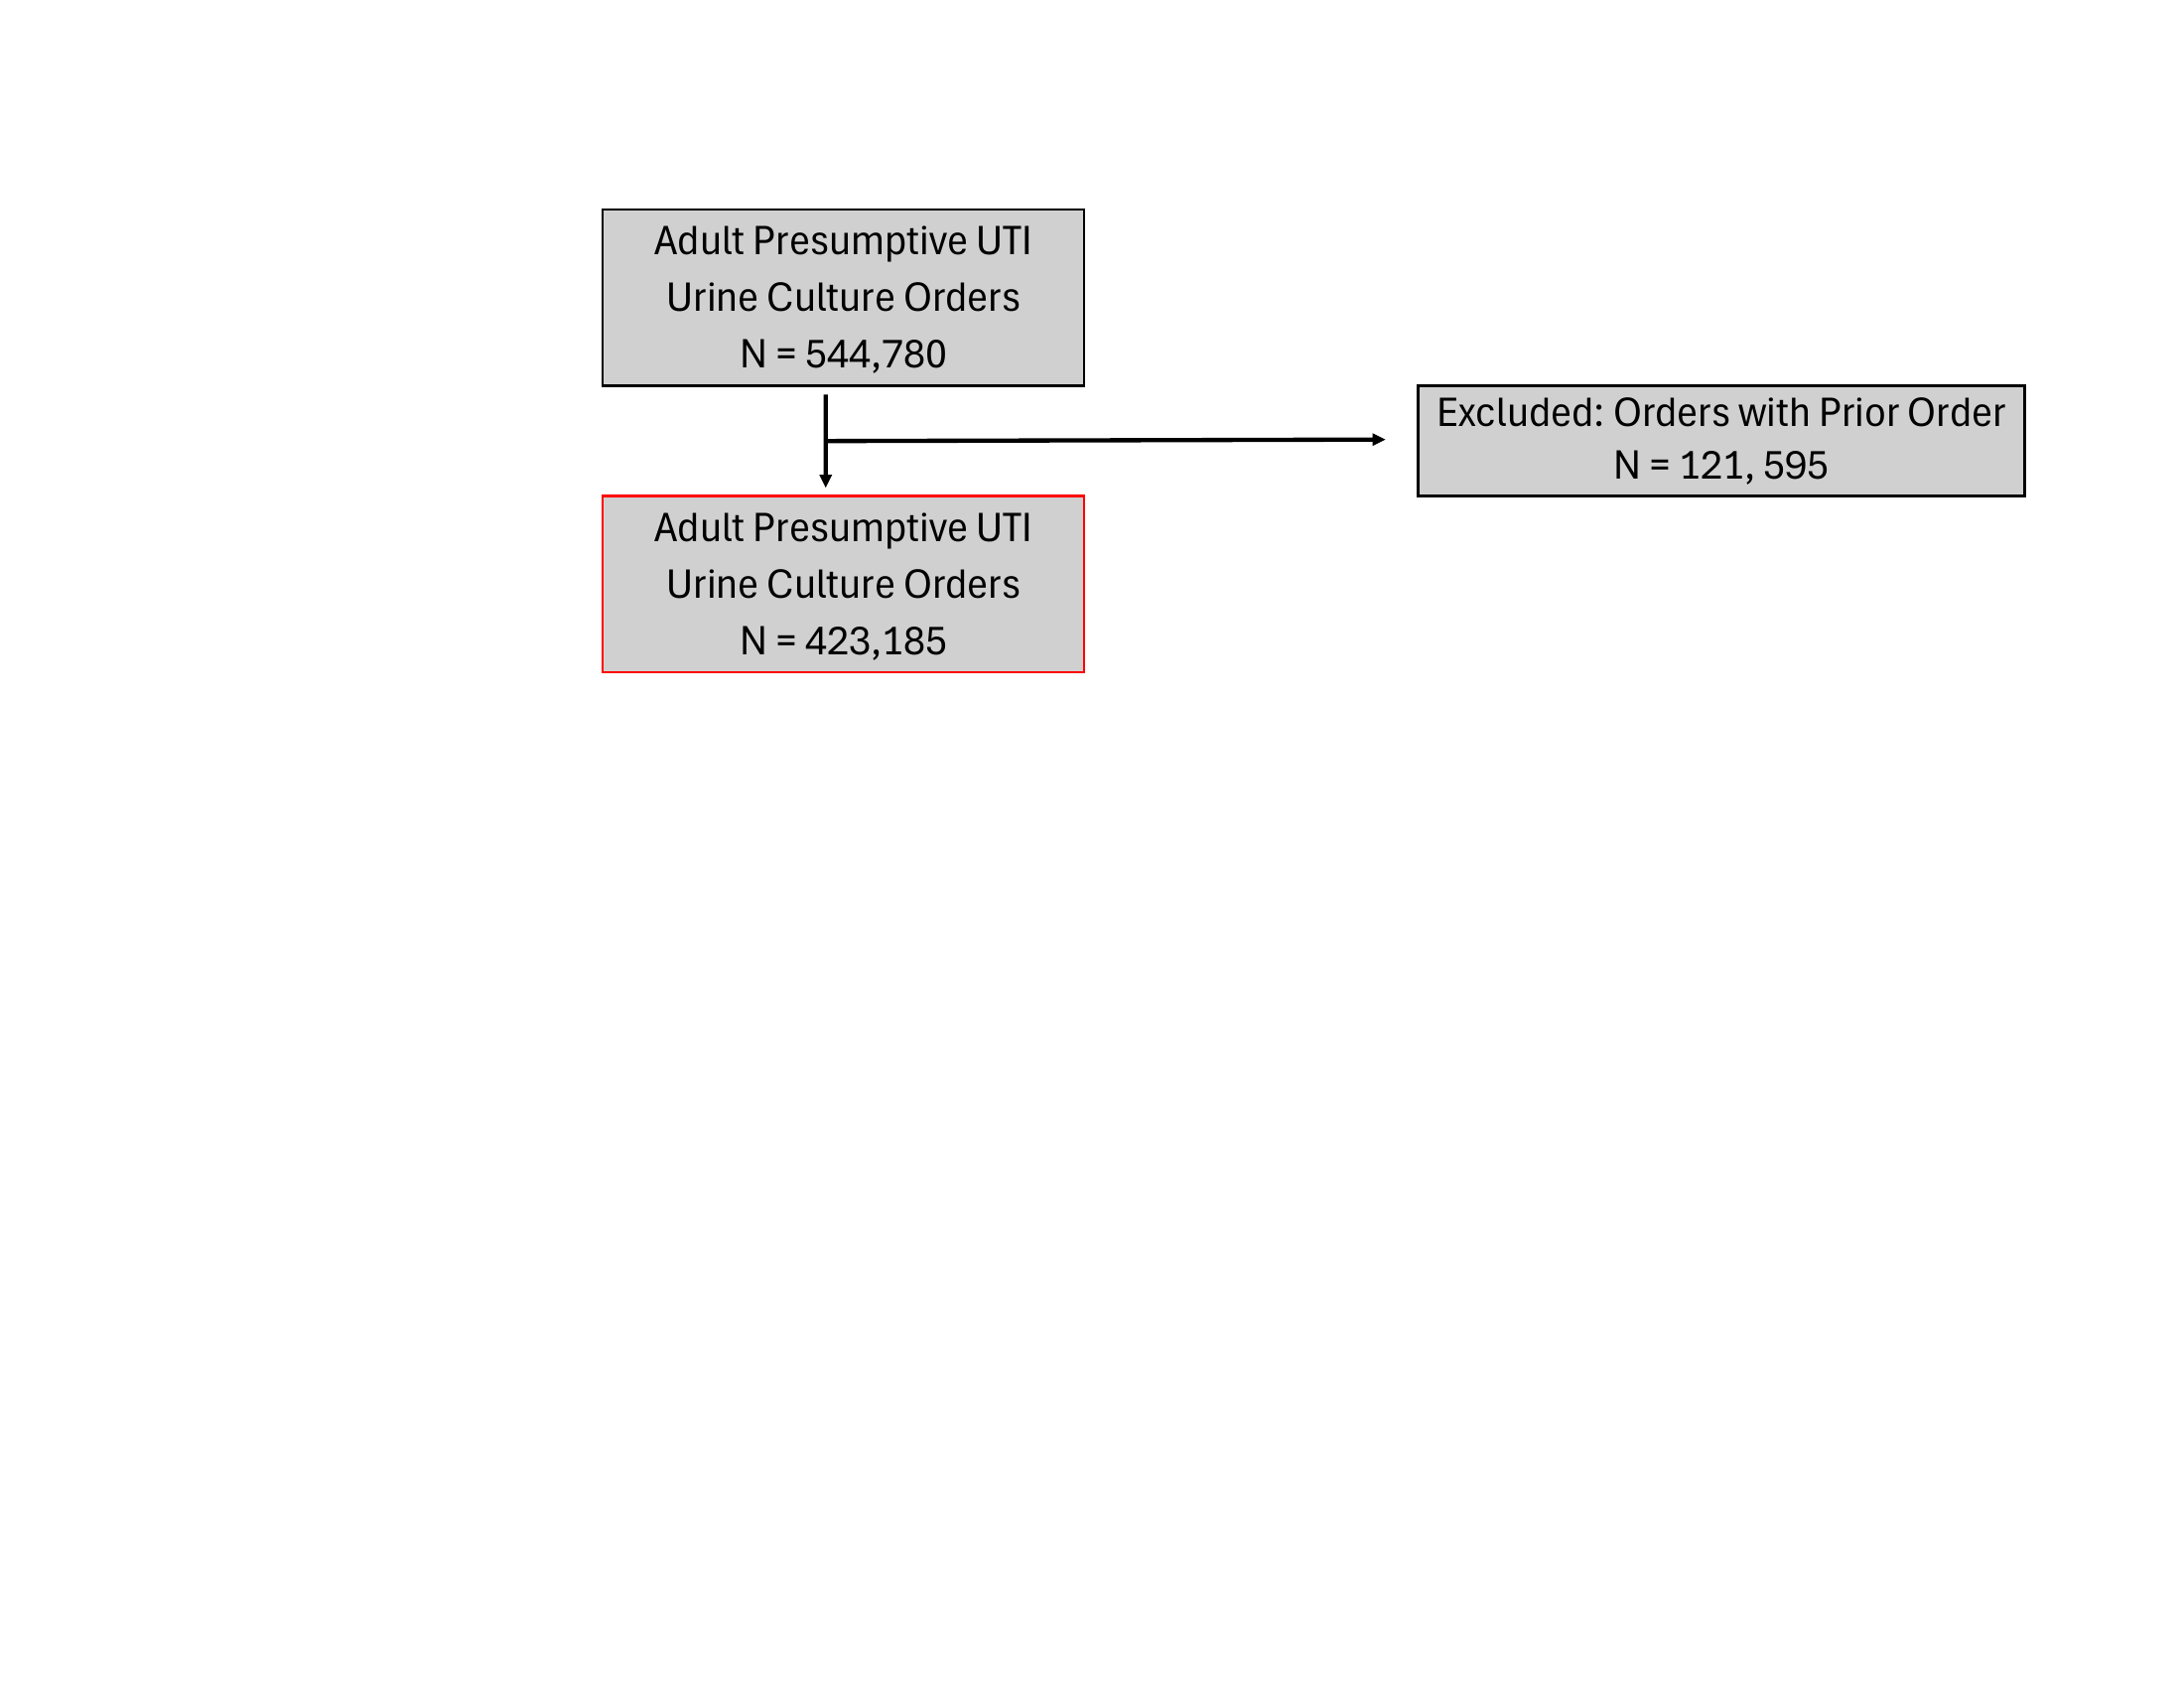

In [ ]:
pages = convert_from_path('Notebook/imgs/Aim_4_Flowchart_Custom.pdf', dpi=200)
path_png = 'Notebook/imgs/step1-2.png'
pages[1].save(path_png, 'PNG')
# Display the image in the notebook
display(Image(filename=path_png))


# ---------------------**Step 3** -----------------------

## 🔍 Verifying Current Medications in the Cohort

To analyze the **current (empirical + non-empirical) medications** for the orders in the above cohort, I applied the following steps:

### ✅ Methodology:
1. **Filtered for current medications only** to focus on active prescriptions.  
2. **Retained the original medication names** without using `regex_express` for modifications.  
3. **Incorporated pharmacy data** (`pharmacy_mar`) after the weekly meeting on **March 20th** to determine whether the ordered medication was actually administered.  

This ensures a more accurate representation of **prescribed vs. administered medications** in the dataset. 🚀

In [ ]:
%%bigquery --use_rest_api current_med_original_no_mapped
##############################################################################################################################################################
# Goal:Creating the microbiology_cultures_prior_med_augmented Table. This table indicates of a patient having been treated with a specific antibiotic before specimen collection.
##############################################################################################################################################################
# CREATE OR REPLACE TABLE `som-nero-phi-jonc101.antimicrobial_stewardship.microbiology_cultures_prior_med_augmented` AS (
WITH base_c AS (
    SELECT DISTINCT
        anon_id,
        pat_enc_csn_id_coded,
        order_proc_id_coded,
        order_time_jittered_utc,
        result_time_jittered_utc
    FROM 
        `som-nero-phi-jonc101.antimicrobial_stewardship_sandy_refactor.microbiology_urine_cultures_cohort`
),
cleaned_medications AS (
    SELECT 
        c.anon_id,
        c.pat_enc_csn_id_coded,
        c.order_proc_id_coded,
        c.order_time_jittered_utc,
        c.result_time_jittered_utc,
        mo.ordering_date_jittered_utc AS medication_time,
        mo.med_description AS medication_name,
        mar.order_med_id_coded,
        mar.mar_action AS medication_action
        # INITCAP(
        #     REGEXP_REPLACE(
        #         REGEXP_REPLACE(
        #             TRIM(
        #                 REGEXP_REPLACE(
        #                     REGEXP_REPLACE(
        #                         REGEXP_REPLACE(
        #                             LOWER(mm.name),  -- Convert to lowercase
        #                             '\\s*\\d+(\\.\\d+)?\\s*(mg|mcg|gram|ml|%)', ''  -- Remove dosages or concentrations
        #                         ),
        #                         '\\(.*?\\)', ''  -- Remove text in parentheses
        #                     ),
        #                     ' in.*$|tablet|capsule|intravenous|piggyback|' ||
        #                     'solution|suspension|oral|sodium|chloride|' ||
        #                     'injection|citrate|soln|dextrose|iv|' ||
        #                     'macrocrystals|macrocrystal|axetil|potassium|packet|' ||
        #                     'monohydrate|ethylsuccinate|powder|mandelate|' ||
        #                     'hyclate|hcl|hippurate|tromethamine|' ||
        #                     'million|unit|syrup|chewable|delayed|mphase|' ||
        #                     'release|benzathine|syringe|dispersible|' ||
        #                     'sulfate|procaine|blue|hyos|sod*phos|' ||
        #                     'susp|and|fosamil|extended|succinate|granules|' ||
        #                     'delay|pot|ext|rel|cyam|salicylate|salicyl|' ||
        #                     'sodphos|methylene|stearate|synergy', ''  -- Remove pharmacy filler words and "synergy"
        #                 )
        #             ),
        #             '\\d|\\sfor\\s*|\\ser\\s*|\\shr\\s*|/ml\\s*|' ||
        #             '\\sml\\s*|\\sv\\s*|\\sg\\s*|\\sim\\s*', ''  -- General cleaning for non-relevant patterns
        #         ),
        #         '\\s|\\/|\\.|-$', ''  -- Remove extra characters like spaces, slashes, dots, etc.
        #     )
        # ) AS medication_name,
        # TIMESTAMP_DIFF(c.order_time_jittered_utc,mo.ordering_date_jittered_utc,day) as medication_time_to_cultureTime,       
    FROM 
        base_c c
    LEFT JOIN 
        `som-nero-phi-jonc101.shc_core_2023.order_med` mo
        using(anon_id, pat_enc_csn_id_coded) # I added "pat_enc_csn_id_coded" to search for current medications
    LEFT JOIN 
        `som-nero-phi-jonc101.shc_core_2023.pharmacy_mar` mar # I incorportedated the pharmacy_mar table to get the medication action
        on mo.anon_id = mar.anon_id 
        and mo.order_med_id_coded = mar.order_med_id_coded
        and mo.pat_enc_csn_id_coded = mar.mar_enc_csn_coded
)

select * 
from cleaned_medications 
group by anon_id,pat_enc_csn_id_coded,order_proc_id_coded,order_time_jittered_utc,result_time_jittered_utc, medication_time, medication_name,order_med_id_coded, medication_action
order by anon_id,pat_enc_csn_id_coded,order_proc_id_coded,order_time_jittered_utc,result_time_jittered_utc, medication_time,medication_name,order_med_id_coded, medication_action

Query is running:   0%|          |

Downloading:   0%|          |

In [123]:
current_med_original_no_mapped

,anon_id,pat_enc_csn_id_coded,order_proc_id_coded,order_time_jittered_utc,result_time_jittered_utc,medication_time,medication_name,order_med_id_coded,medication_action
0,JC1000010,15404221,325204620,2008-05-12 03:14:00+00:00,2008-05-13 00:42:00+00:00,NaT,None,None,None
1,JC1000013,15174722,302914865,2008-04-11 23:45:00+00:00,2008-04-13 02:50:00+00:00,NaT,None,None,None
2,JC1000021,32992898,351382857,2009-06-06 23:12:00+00:00,2009-06-09 00:00:00+00:00,NaT,None,None,None
3,JC1000021,131009159044,366795029,2010-05-29 23:22:00+00:00,2010-06-01 00:13:00+00:00,2010-05-29 07:00:00+00:00,MONTELUKAST 10 MG PO TABS,None,None
4,JC1000022,15142402,323829550,2008-03-13 03:50:00+00:00,2008-03-14 03:14:00+00:00,NaT,None,None,None
...,...,...,...,...,...,...,...,...,...
12834705,JC999925,131107270857,471989931,2015-08-09 09:12:00+00:00,2015-08-11 14:59:00+00:00,2015-08-20 07:00:00+00:00,HELP ORDER,None,None
12834706,JC999925,131107270857,471989931,2015-08-09 09:12:00+00:00,2015-08-11 14:59:00+00:00,2015-08-20 07:00:00+00:00,SERTRALINE 50 MG PO TABS,None,None
12834707,JC999935,14537303,312599852,2005-07-23 19:47:00+00:00,2005-07-25 18:27:00+00:00,NaT,None,None,None
12834708,JC999992,131189547541,497201103,2016-06-06 03:57:00+00:00,2016-06-08 00:36:00+00:00,NaT,None,None,None


In [125]:
# we check the unique order number for current_med_original_no_mapped and starting_cohort
assert find_unique_orders(current_med_original_no_mapped) == find_unique_orders(starting_cohort), "Unique order counts do not match between current_med_original_no_mapped and starting_cohort"

In [124]:
current_med_original_no_mapped["medication_action"].value_counts()

medication_action
Given                    4419561
Missed                   1105033
New Bag                  1020777
Completed                 477302
Rate Verify               454898
                          ...   
Oral Contrast Started         20
L&D Rate Change                5
Downtime/New Syringe           4
Leech(es) applied              1
Leech(es) removed              1
Name: count, Length: 72, dtype: int64

# --------------------- Step 3.1 -----------------------

## 🛠️ Cleaning Up Medication Categories

### Since the original names were retained, I will now categorize the medications into **antibiotic** and **non-antibiotic** groups.

### 📌 Legend:
- **None** → No medication prescribed  
- **No Match** → A **non-antibiotic** medication was prescribed  
- **Else** → An **antibiotic** medication was prescribed  

In [126]:
# this line is to clean the medication
current_med_original_no_mapped["cleaned_antibiotic"] = current_med_original_no_mapped["medication_name"].apply(
    lambda x: find_antibiotics(x, antibiotic_list)
)

In [264]:
current_med_original_no_mapped.iloc[135:147]

,anon_id,pat_enc_csn_id_coded,order_proc_id_coded,order_time_jittered_utc,result_time_jittered_utc,medication_time,medication_name,order_med_id_coded,medication_action,cleaned_antibiotic
135,JC1000129,131354606122,877003103,2023-04-24 01:28:00+00:00,2023-04-26 01:57:00+00:00,2023-04-24 07:00:00+00:00,MAGNESIUM SULFATE IN D5W 1 GRAM/100 ML IV PGBK,None,None,No Match
136,JC1000129,131354606122,877003103,2023-04-24 01:28:00+00:00,2023-04-26 01:57:00+00:00,2023-04-24 07:00:00+00:00,MAGNESIUM SULFATE IN WATER 2 GRAM/50 ML (4 %) ...,None,None,No Match
137,JC1000129,131354606122,877003103,2023-04-24 01:28:00+00:00,2023-04-26 01:57:00+00:00,2023-04-24 07:00:00+00:00,MEROPENEM 1 GRAM/50 ML NS MINIBAG PLUS,None,None,[Meropenem]
138,JC1000129,131354606122,877003103,2023-04-24 01:28:00+00:00,2023-04-26 01:57:00+00:00,2023-04-24 07:00:00+00:00,MEROPENEM 1 GRAM/50 ML NS MINIBAG PLUS,877049773.000000000,Completed,[Meropenem]
139,JC1000129,131354606122,877003103,2023-04-24 01:28:00+00:00,2023-04-26 01:57:00+00:00,2023-04-24 07:00:00+00:00,MEROPENEM 1 GRAM/50 ML NS MINIBAG PLUS,877049773.000000000,New Bag,[Meropenem]
140,JC1000129,131354606122,877003103,2023-04-24 01:28:00+00:00,2023-04-26 01:57:00+00:00,2023-04-24 07:00:00+00:00,MEROPENEM 1 GRAM/50 ML NS MINIBAG PLUS,877049773.000000000,Paused,[Meropenem]
141,JC1000129,131354606122,877003103,2023-04-24 01:28:00+00:00,2023-04-26 01:57:00+00:00,2023-04-24 07:00:00+00:00,MEROPENEM 1 GRAM/50 ML NS MINIBAG PLUS,877049773.000000000,Rate Change,[Meropenem]
142,JC1000129,131354606122,877003103,2023-04-24 01:28:00+00:00,2023-04-26 01:57:00+00:00,2023-04-24 07:00:00+00:00,MEROPENEM 1 GRAM/50 ML NS MINIBAG PLUS,877049773.000000000,Rate Verify,[Meropenem]
143,JC1000129,131354606122,877003103,2023-04-24 01:28:00+00:00,2023-04-26 01:57:00+00:00,2023-04-24 07:00:00+00:00,MEROPENEM 1 GRAM/50 ML NS MINIBAG PLUS,877049773.000000000,Restarted,[Meropenem]
144,JC1000129,131354606122,877003103,2023-04-24 01:28:00+00:00,2023-04-26 01:57:00+00:00,2023-04-24 07:00:00+00:00,MULTIVITAMIN (GENERIC) PO TABS,877243176.000000000,Given,No Match


In [137]:
culture_order_with_any_cur_med =  current_med_original_no_mapped[current_med_original_no_mapped["cleaned_antibiotic"].notnull()]
culture_order_without_any_cur_med =  current_med_original_no_mapped[current_med_original_no_mapped["cleaned_antibiotic"].isnull()]
print("the unique order number for culture_order_with_any_cur_med is {}".format(find_unique_orders(culture_order_with_any_cur_med)))
print("the unique order number for culture_order_without_any_cur_med is {}".format(find_unique_orders(culture_order_without_any_cur_med)))

the unique order number for culture_order_with_any_cur_med is 216783
the unique order number for culture_order_without_any_cur_med is 206402


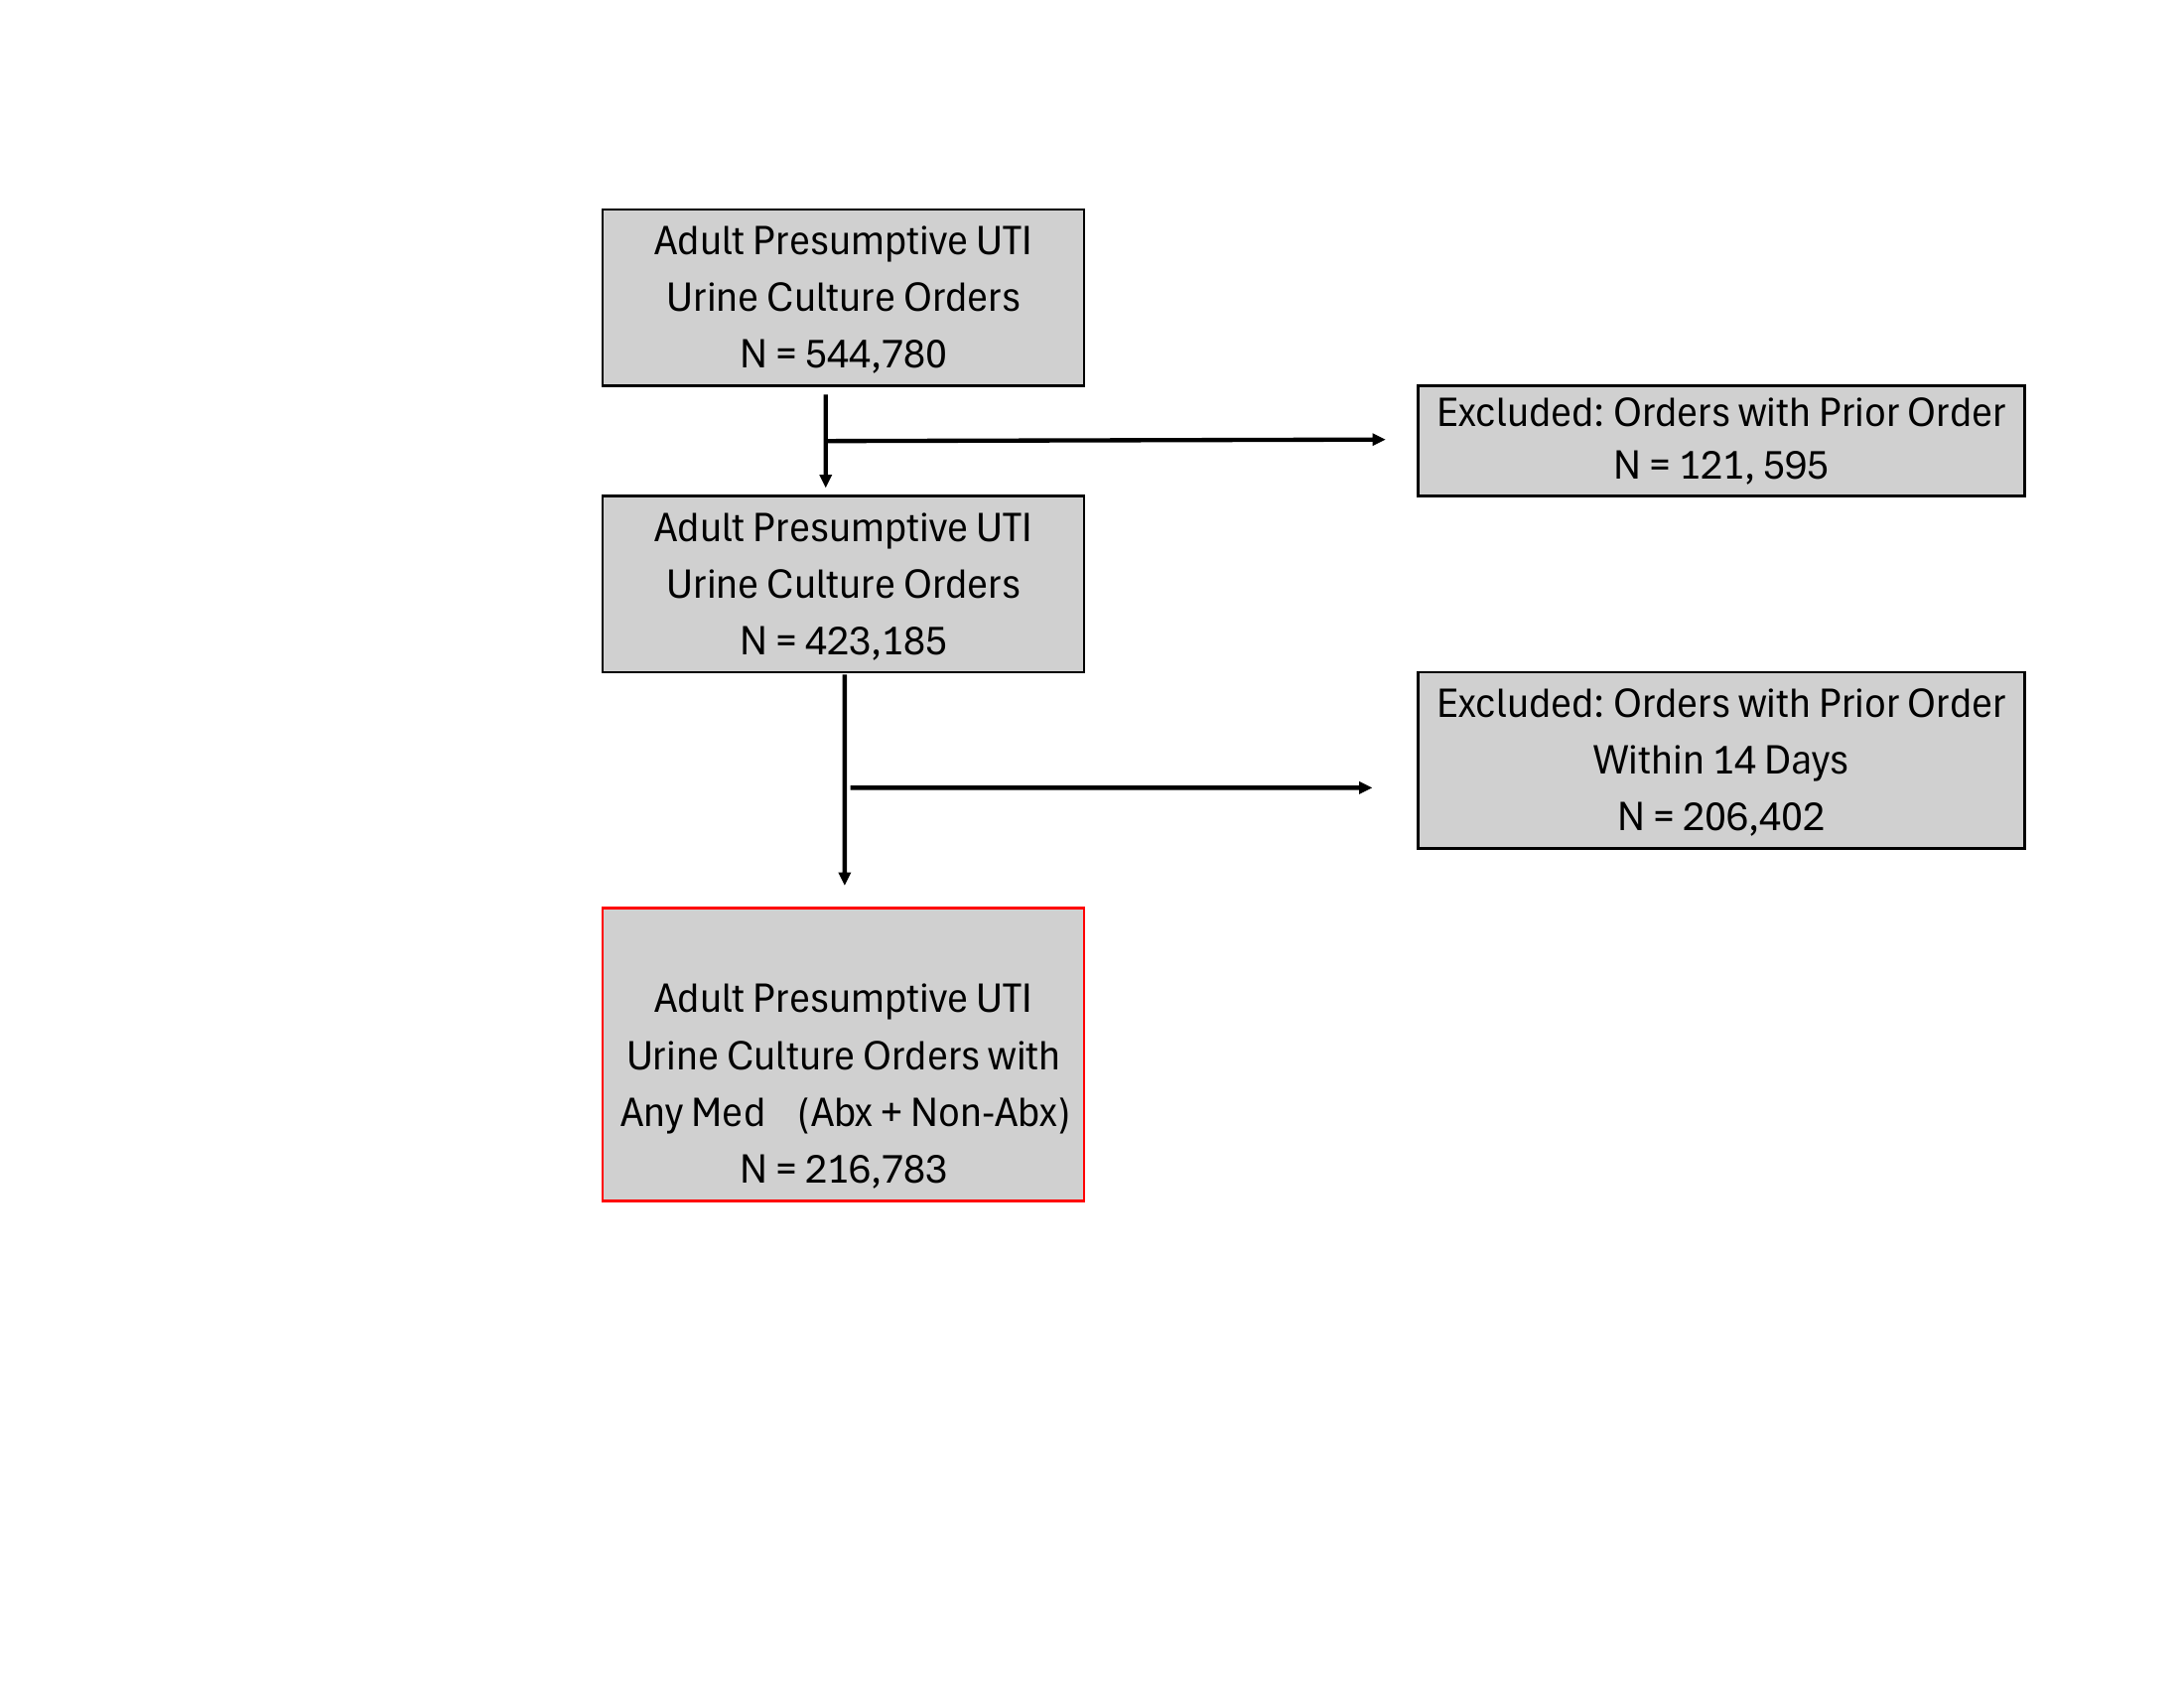

In [250]:
pages = convert_from_path('Notebook/imgs/Aim_4_Flowchart_Custom.pdf', dpi=200)
path_png = 'Notebook/imgs/step3.png'
pages[2].save(path_png, 'PNG')
# Display the image in the notebook
display(Image(filename=path_png))

## We can further categorize `culture_order_with_any_cur_med` into antibiotic med and non-antibiotic med

In [138]:
culture_order_with_abx_med = culture_order_with_any_cur_med[culture_order_with_any_cur_med["cleaned_antibiotic"] != "No Match"]
culture_order_with_non_abx_med = culture_order_with_any_cur_med[culture_order_with_any_cur_med["cleaned_antibiotic"] == "No Match"]
print("the unique order number for culture_order_with_abx_med is {}".format(find_unique_orders(culture_order_with_abx_med)))
print("the unique order number for culture_order_with_non_abx_med is {}".format(find_unique_orders(culture_order_with_non_abx_med)))

the unique order number for culture_order_with_abx_med is 156314
the unique order number for culture_order_with_non_abx_med is 184104


## 📌 Understanding the Discrepancy in Order Counts

The reason why **(156,314 + 184,104) ≠ 216,783** is because:

- For one **order**, multiple **medications** can be prescribed.
- An order may include **both an antibiotic and a non-antibiotic**.

### 📊 Key Breakdown:
- **Total unique orders with any current medication:** `216,783`
- **Unique orders with at least one antibiotic (`abx_med`):** `156,314`
- **Unique orders without any antibiotics:**
  
  \[
    Total unique orders with current medication - Unique orders with an antibiotic 
  \]

  \[
  216,783 - 156,314 = **60,469**
  \]

Thus, the **60,469 orders** had at least one **non-antibiotic** medication but no antibiotics.

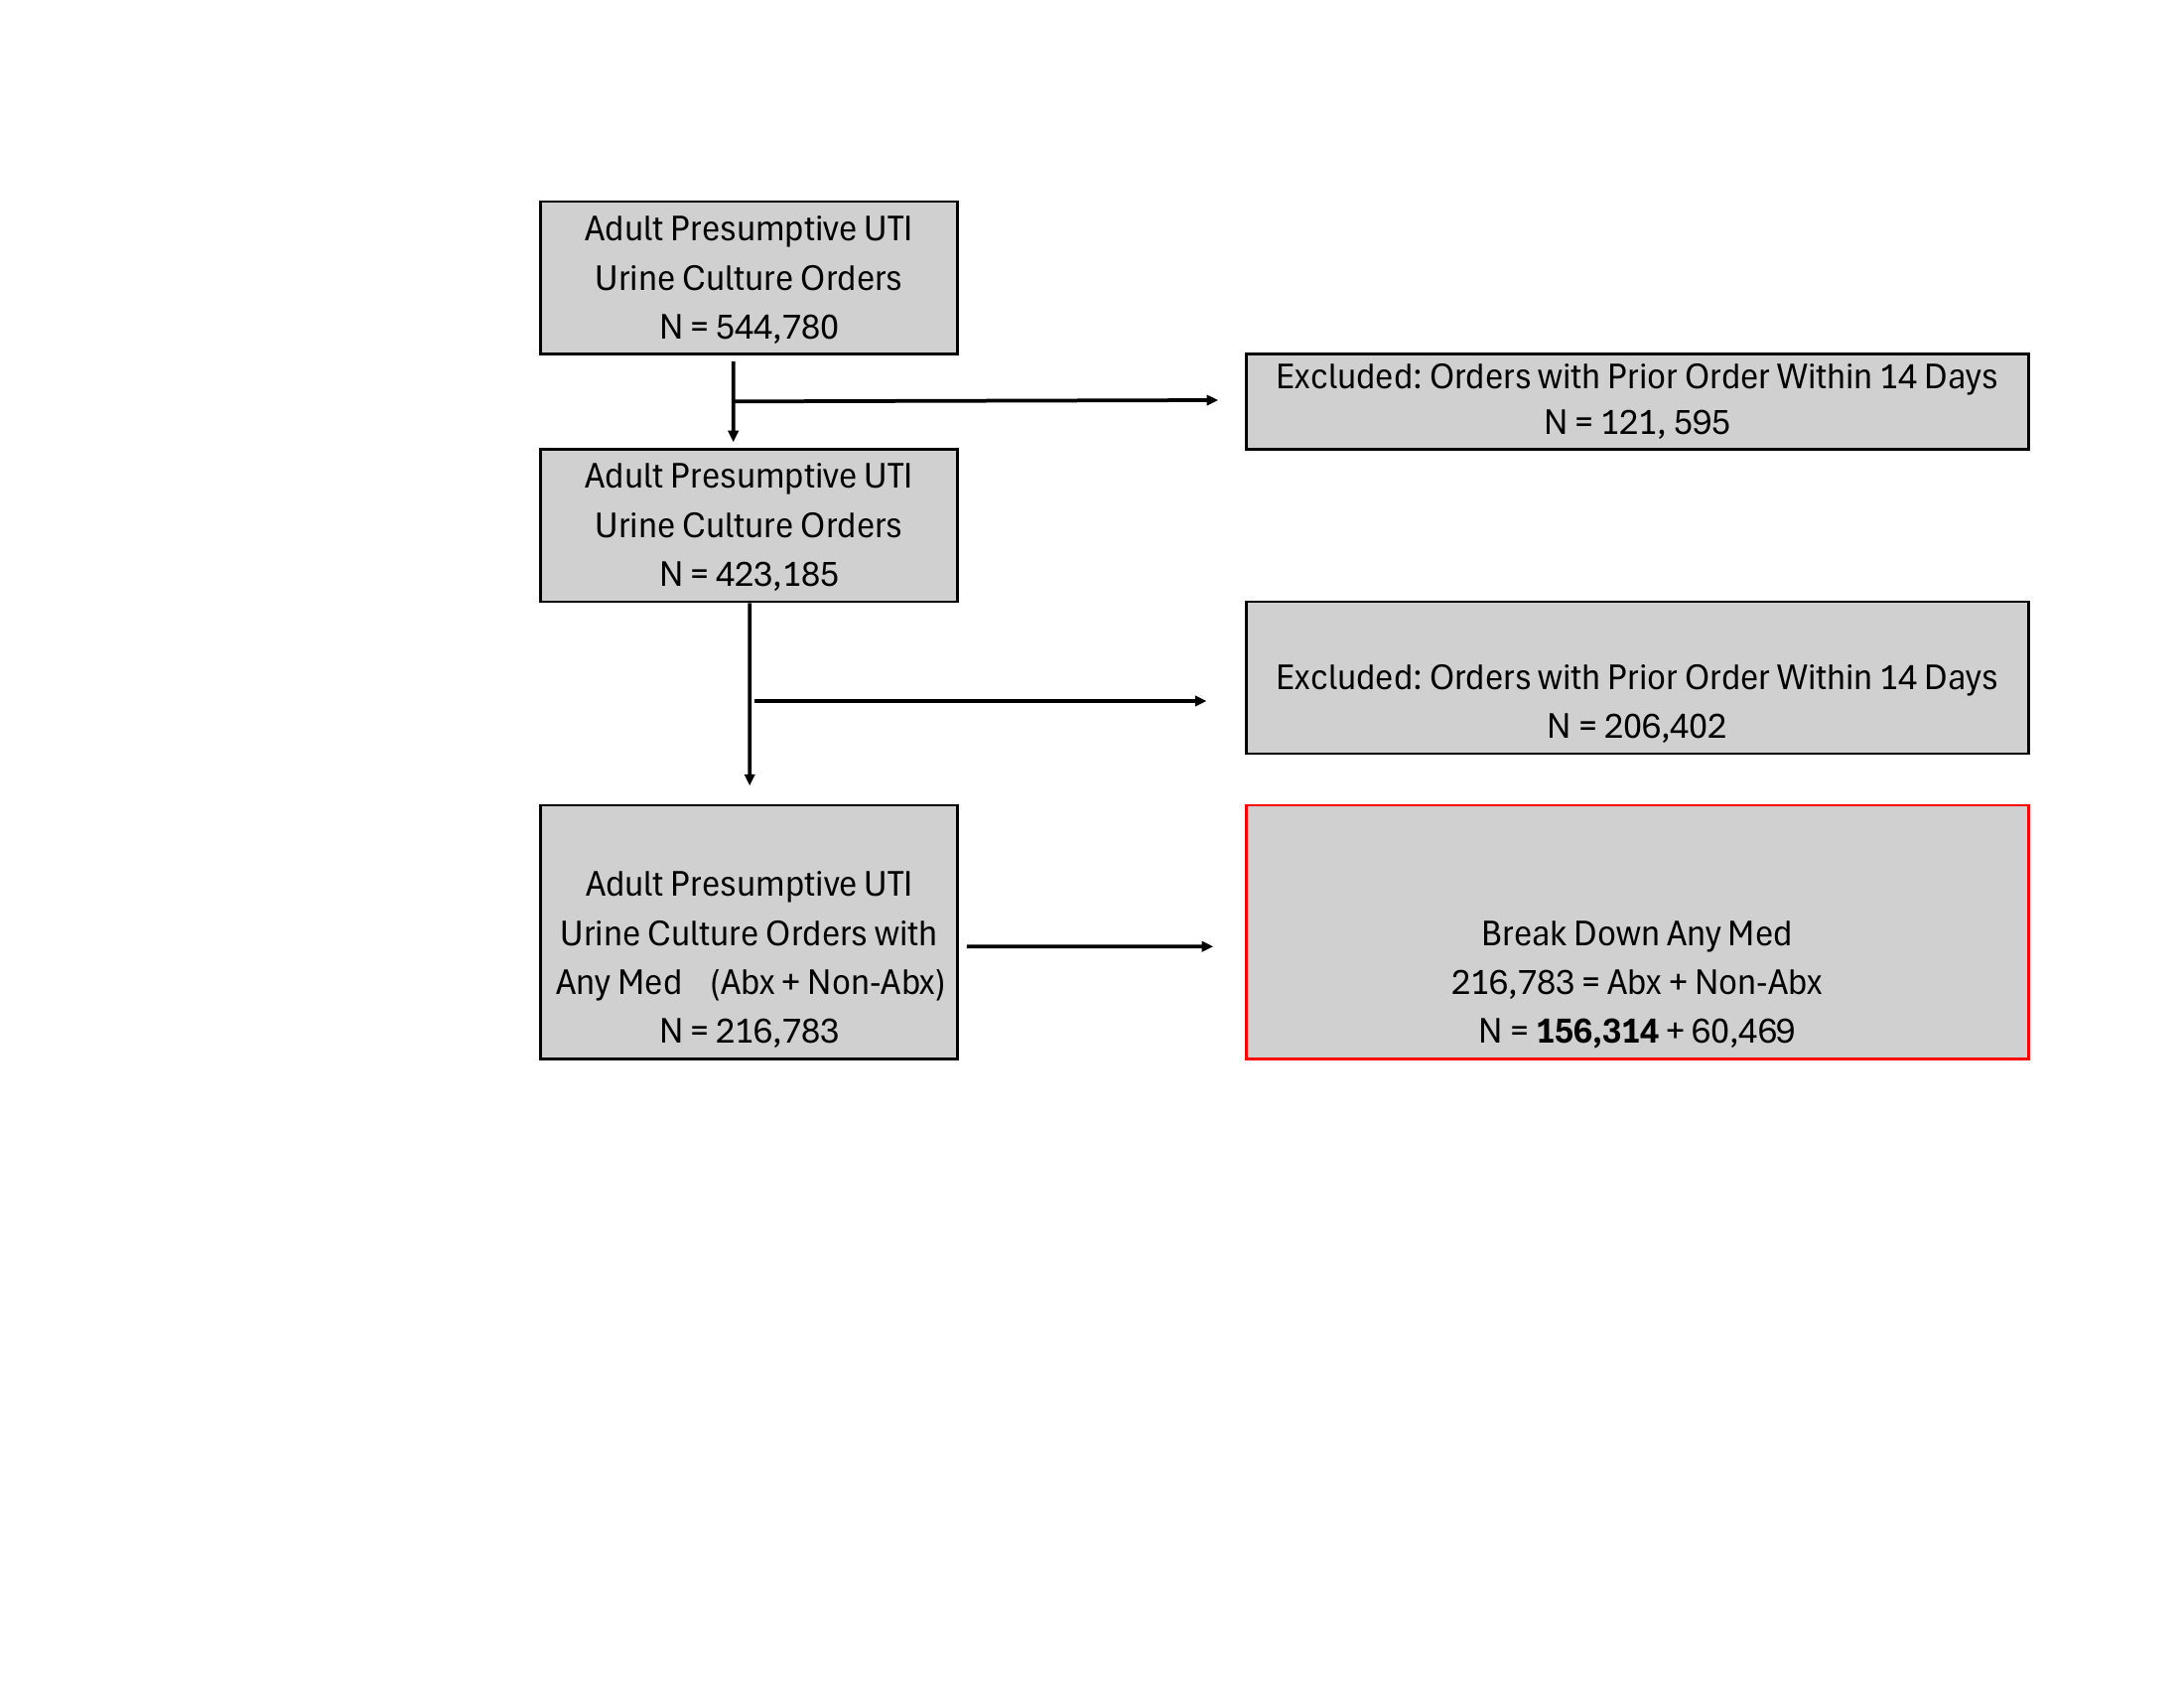

In [249]:
pages = convert_from_path('Notebook/imgs/Aim_4_Flowchart_Custom.pdf', dpi=200)
path_png = 'Notebook/imgs/step3-1.png'
pages[3].save(path_png, 'PNG')
# Display the image in the notebook
display(Image(filename=path_png))

# ------------------------------ Step 3.2 ----------------------------

## 🔍 Verifying Antibiotic Administration in Orders

From the above analysis, we observe that:

- The total number of **culture orders** associated with at least one **antibiotic (`abx_med`)** is **156,314**.
- Now, we need to determine how many of these **antibiotic medications were actually administered**.

This check will help confirm whether all prescribed **antibiotic orders** were followed through with actual medication administration. 🚀

In [157]:
culture_order_with_abx_med_given = culture_order_with_abx_med[culture_order_with_abx_med["medication_action"] == "Given"]
culture_order_with_abx_med_non_given = culture_order_with_abx_med[culture_order_with_abx_med["medication_action"]!= "Given"]

In [158]:
print("the unique order number for culture_order_with_abx_med_given is {}".format(find_unique_orders(culture_order_with_abx_med_given)))
print("the unique order number for culture_order_with_abx_med_non_given is {}".format(find_unique_orders(culture_order_with_abx_med_non_given)))

the unique order number for culture_order_with_abx_med_given is 89025
the unique order number for culture_order_with_abx_med_non_given is 147673


## 🔍 Understanding the Discrepancy in Antibiotic Orders

Similarly, **(89,025 + 147,673) ≠ 156,314** because:

- A single **order** can have multiple **medication actions** associated with it.
- An order may include **both "Given" and "Non-Given" medications**.

### 📊 Key Breakdown:
- **Total culture orders with an antibiotic (`abx_med`):** `156,314`
- **Orders where at least one antibiotic was **administered** (`Given`):** `89,025`
- **Orders where antibiotics were **not given** (`Non-Given`):** `147,673`
Because one order administration can associate with many actions,
- **Unique orders with antibiotic not given:**
  
  \[
    Total unique orders with antibiotic medication - Unique orders with administered antibiotic medication 
  \]

  \[
  156,314 - 89,025 = **67289**
  \]

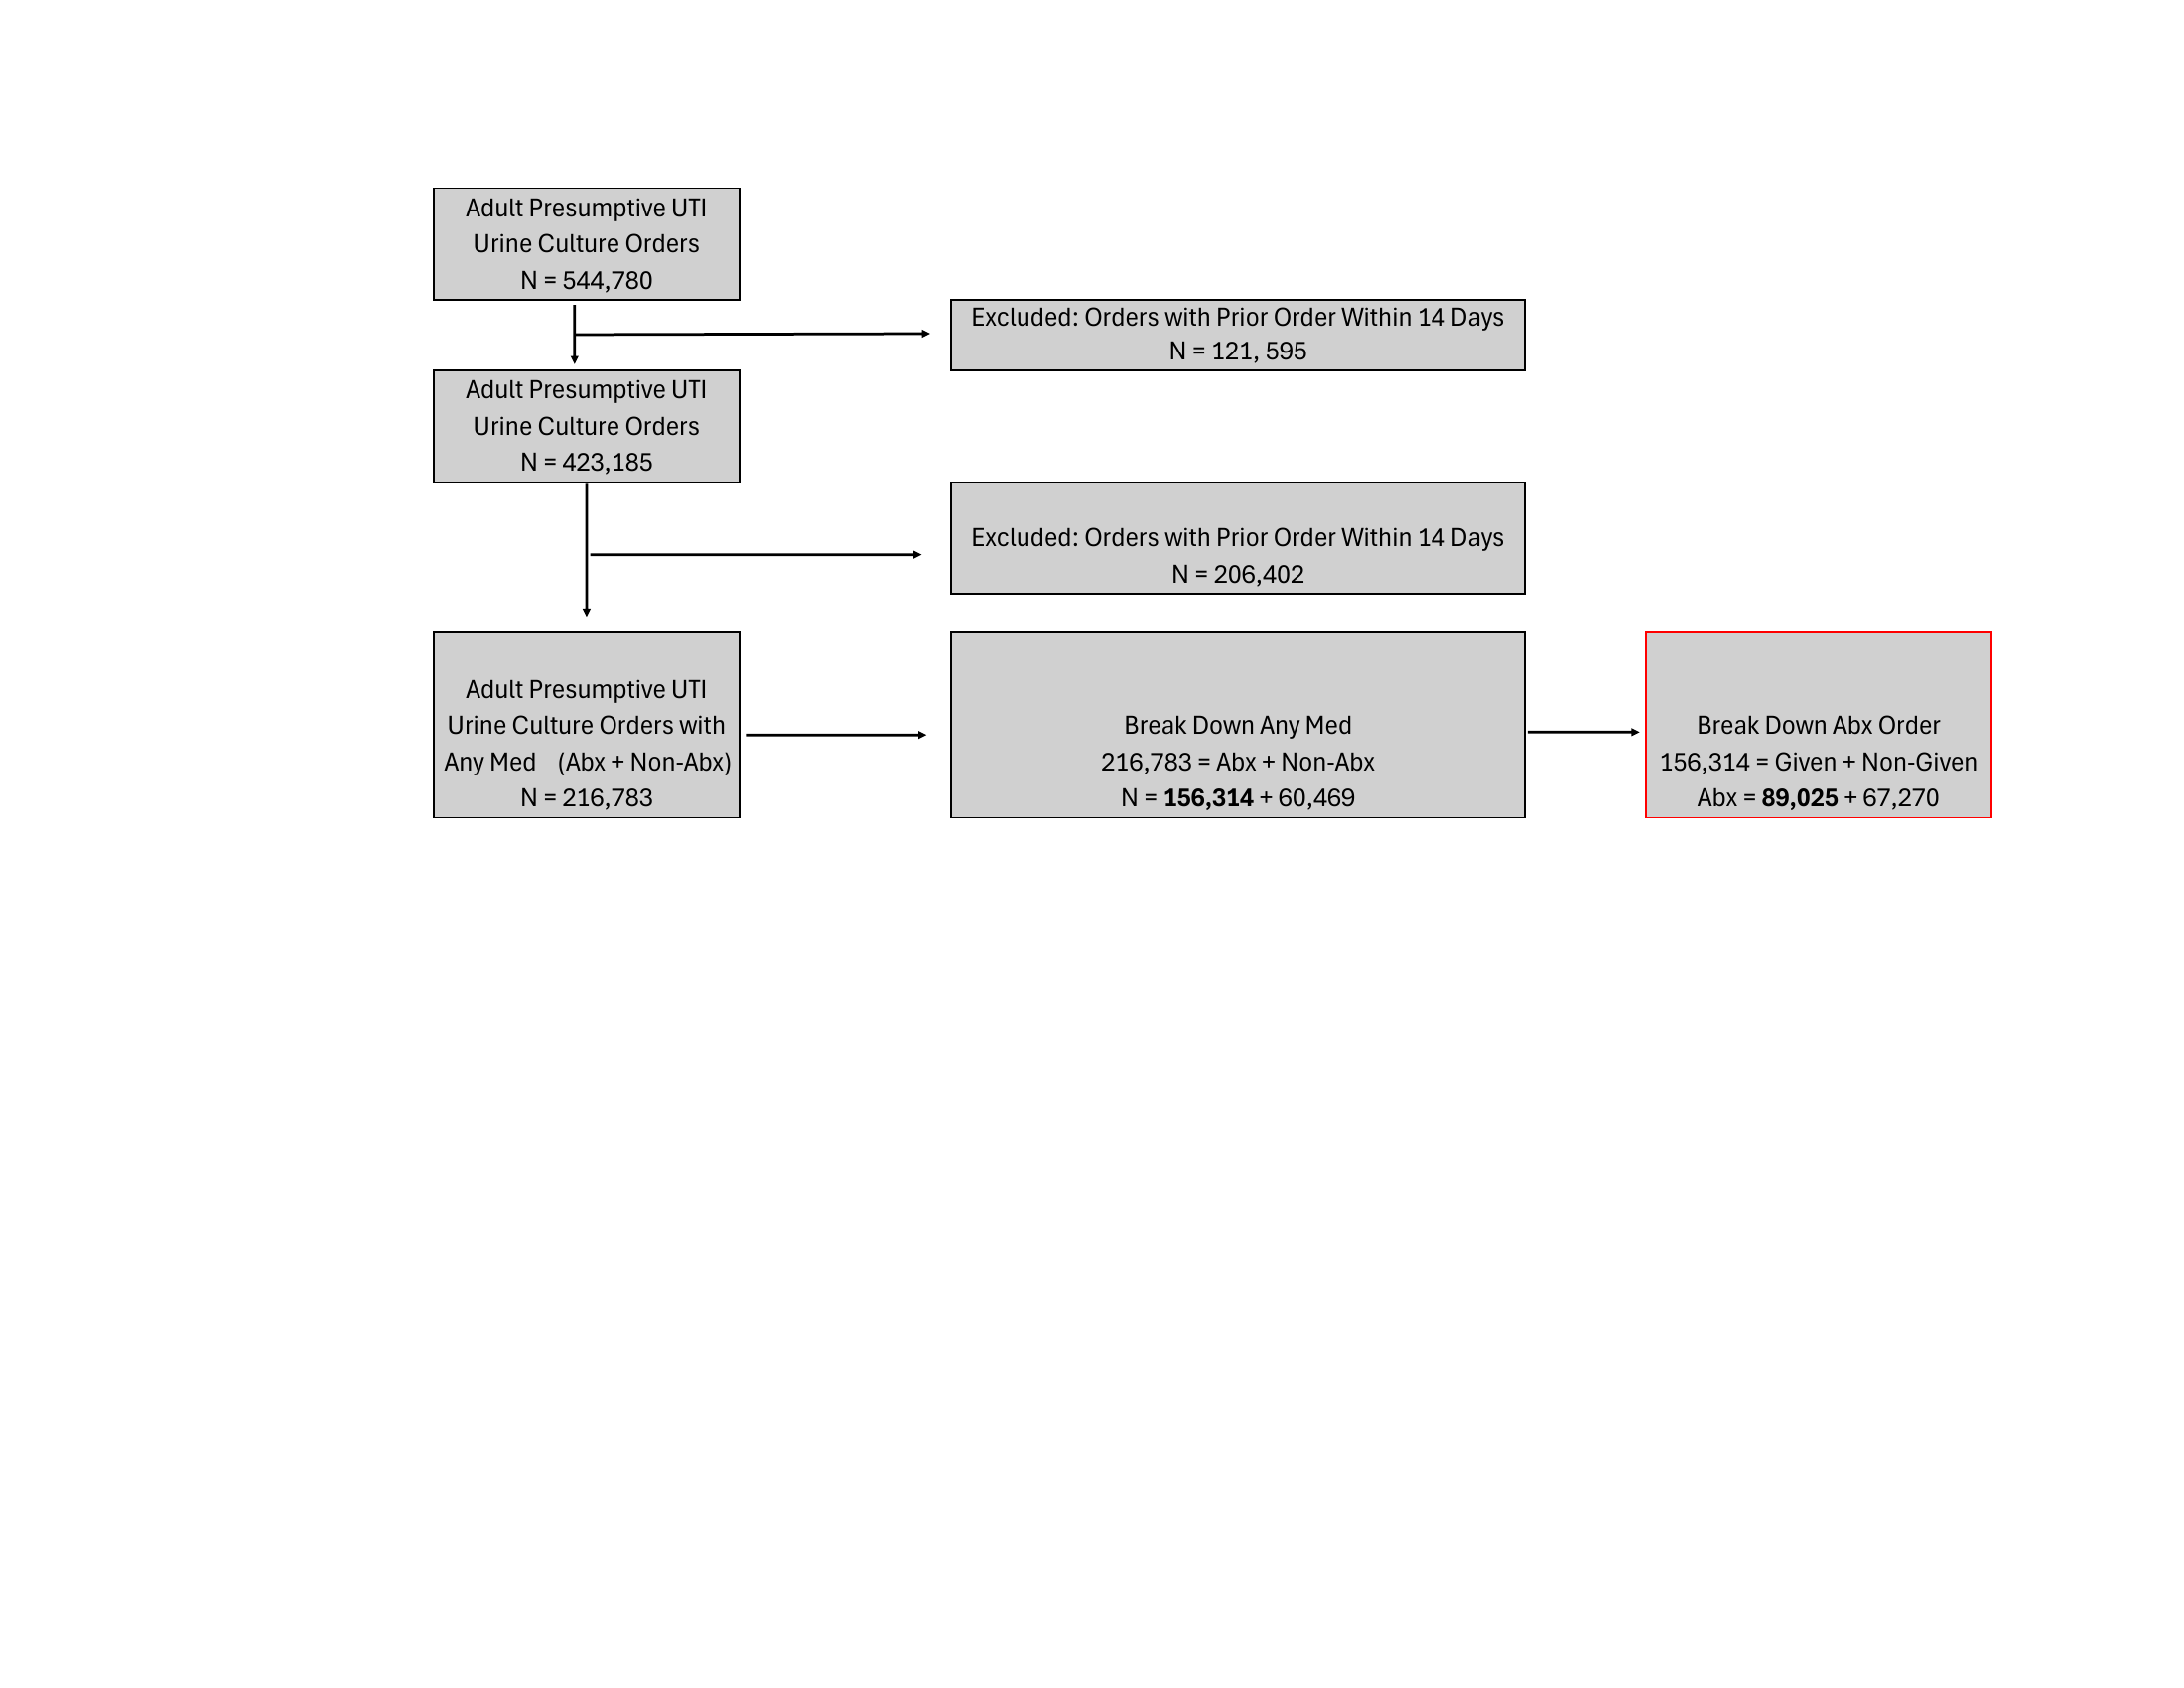

In [251]:
pages = convert_from_path('Notebook/imgs/Aim_4_Flowchart_Custom.pdf', dpi=200)
path_png = 'Notebook/imgs/step3-2.png'
pages[4].save(path_png, 'PNG')
# Display the image in the notebook
display(Image(filename=path_png))


In [162]:
# This also brings up another problem: how do we actually want to evaluate appropriteness of medication prescription for one culture order.
# Nick could talk more about this
# Count number of rows per group
group_counts = culture_order_with_abx_med_given.groupby(
    ['anon_id', 'pat_enc_csn_id_coded', 'order_proc_id_coded', 'order_time_jittered_utc']
)['cleaned_antibiotic'].transform('count')

# Filter rows where group count is greater than 1
group_counts_df= culture_order_with_abx_med_given[group_counts > 1]
sorted_group_counts_df = group_counts_df.sort_values(by=['anon_id', 'pat_enc_csn_id_coded', 'order_proc_id_coded', 'order_time_jittered_utc'])
# sorted_group_counts_df.head(50)

In [ ]:
sorted_group_counts_df
# JC999856	23290259	338723165, this example is good to show multiple medication scenario

# ---------------------------------**Step 4** ---------------------------

### Refactor Fateme's code for ward info in order to select ED order
Reference: https://github.com/HealthRex/CDSS/blob/master/scripts/antibiotic-susceptibility/sql/queries/microbiology_cultures_ward_info.sql

In [10]:
%%bigquery --use_rest_api df_hosp_ward_info
WITH
-- Step 1: Extract ER and ICU Information from adt Table
temp_er_icu_info_adt AS (
    SELECT
        anon_id,
        pat_enc_csn_id_coded,
        CASE 
            WHEN pat_class = 'Emergency' OR pat_class = 'Emergency Services' THEN 1
            ELSE 0
        END AS hosp_ward_ER,
        CASE 
            WHEN pat_class = 'Intensive Care (IC)' THEN 1
            ELSE 0
        END AS hosp_ward_ICU,
        CASE 
            WHEN pat_lv_of_care LIKE "%Critical Care" THEN 1
            ELSE 0
        END AS hosp_ward_Critical_Care
    FROM
        `som-nero-phi-jonc101.shc_core_2023.adt`
),

-- Step 2: Extract ER Information from order_proc Table
temp_er_info_order_proc AS (
    SELECT
        anon_id,
        pat_enc_csn_id_coded,
        order_proc_id_coded,
        CASE 
            WHEN proc_pat_class = 'Emergency' OR proc_pat_class = 'Emergency Services' THEN 1
            ELSE 0
        END AS hosp_ward_ER_order_proc
    FROM
        `som-nero-phi-jonc101.shc_core_2023.order_proc`
),

-- Step 3: Combine ER and ICU Information
temp_combined_er_icu_info AS (
    SELECT
        adt.anon_id,
        adt.pat_enc_csn_id_coded,
        adt.hosp_ward_ER,
        adt.hosp_ward_ICU,
        adt.hosp_ward_Critical_Care,
        er.order_proc_id_coded,
        er.hosp_ward_ER_order_proc
    FROM
        temp_er_icu_info_adt adt
    LEFT JOIN
        temp_er_info_order_proc er
    ON
        adt.pat_enc_csn_id_coded = er.pat_enc_csn_id_coded
),

-- Step 4: Extract IP and OP Information from order_proc Table
temp_ip_op_info AS (
    SELECT
        anon_id,
        pat_enc_csn_id_coded,
        order_proc_id_coded,
        order_time_jittered_utc,
        CASE 
            WHEN ordering_mode = 'Inpatient' THEN 1
            ELSE 0
        END AS hosp_ward_IP,
        CASE 
            WHEN ordering_mode = 'Outpatient' THEN 1
            ELSE 0
        END AS hosp_ward_OP
    FROM
        `som-nero-phi-jonc101.shc_core_2023.order_proc`
),

-- Step 5: Combine All Information into One Temporary Table
temp_combined_hosp_ward_info AS (
    SELECT
        ipop.anon_id,
        ipop.pat_enc_csn_id_coded,
        ipop.order_proc_id_coded,
        ipop.order_time_jittered_utc,
        ipop.hosp_ward_IP,
        ipop.hosp_ward_OP,
        COALESCE(icu.hosp_ward_ER, 0) AS hosp_ward_ER_adt,
        COALESCE(icu.hosp_ward_ER_order_proc, 0) AS hosp_ward_ER_order_proc,
        COALESCE(icu.hosp_ward_ICU, 0) AS hosp_ward_ICU,
        COALESCE(icu.hosp_ward_Critical_Care, 0) AS hosp_ward_Critical_Care
    FROM
        temp_ip_op_info ipop
    LEFT JOIN
        temp_combined_er_icu_info icu
    ON
        ipop.pat_enc_csn_id_coded = icu.pat_enc_csn_id_coded AND ipop.order_proc_id_coded = icu.order_proc_id_coded
),

-- Step 6: Extract ICU stay based on transfer orders
temp_cohortOfInterest AS (
    SELECT DISTINCT
        pat_enc_csn_id_coded,
        hosp_disch_time_jittered_utc
    FROM `som-nero-phi-jonc101.shc_core_2023.encounter`
    WHERE hosp_disch_time_jittered_utc IS NOT NULL
),

temp_ordersTransfer AS (
    SELECT DISTINCT
        pat_enc_csn_id_coded,
        description,
        level_of_care,
        service,
        order_inst_jittered_utc
    FROM `som-nero-phi-jonc101.shc_core_2023.order_proc` AS procedures
    WHERE (description LIKE "CHANGE LEVEL OF CARE/TRANSFER PATIENT" OR description LIKE "ADMIT TO INPATIENT") AND level_of_care IS NOT NULL
),

temp_icuTransferCount AS (
    SELECT
        mc.pat_enc_csn_id_coded,
        COUNT(CASE WHEN level_of_care LIKE "Critical Care" THEN 1 END) AS numICUTransfers
    FROM
       `som-nero-phi-jonc101.antimicrobial_stewardship_sandy_refactor.microbiology_urine_cultures_cohort` mc # only change this to the starting cohort above
    LEFT JOIN
        temp_ordersTransfer ot
    ON
        mc.pat_enc_csn_id_coded = ot.pat_enc_csn_id_coded
    GROUP BY
        mc.pat_enc_csn_id_coded
),

microbiology_cultures_with_icu_flag AS (
    SELECT DISTINCT
        mc.anon_id,
        mc.pat_enc_csn_id_coded,
        mc.order_proc_id_coded,
        mc.order_time_jittered_utc,
        CASE WHEN itc.numICUTransfers > 0 THEN 1 ELSE 0 END AS icu_flag
    FROM
       `som-nero-phi-jonc101.antimicrobial_stewardship_sandy_refactor.microbiology_urine_cultures_cohort` mc
    LEFT JOIN
        temp_icuTransferCount itc
    ON
        mc.pat_enc_csn_id_coded = itc.pat_enc_csn_id_coded
)

-- Step 7: Create the Final Table with Correct Binary Indicators for Each Hospital Ward and ICU Flag
SELECT
    mc.anon_id,
    mc.pat_enc_csn_id_coded,
    mc.order_proc_id_coded,
    mc.order_time_jittered_utc,
    MAX(CASE WHEN chwi.hosp_ward_IP = 1 THEN 1 ELSE 0 END) AS hosp_ward_IP,
    MAX(CASE WHEN chwi.hosp_ward_OP = 1 THEN 1 ELSE 0 END) AS hosp_ward_OP,
    MAX(CASE WHEN chwi.hosp_ward_ER_adt = 1 OR chwi.hosp_ward_ER_order_proc = 1 THEN 1 ELSE 0 END) AS hosp_ward_ER,
    MAX(
        CASE 
            WHEN chwi.hosp_ward_ICU = 1 THEN 1 
            WHEN icu_flag.icu_flag = 1 THEN 1 
            WHEN chwi.hosp_ward_Critical_Care = 1 THEN 1
            ELSE 0 
        END
    ) AS hosp_ward_ICU
FROM
   `som-nero-phi-jonc101.antimicrobial_stewardship_sandy_refactor.microbiology_urine_cultures_cohort` mc
LEFT JOIN
    temp_combined_hosp_ward_info chwi
ON
    mc.anon_id = chwi.anon_id 
    AND mc.pat_enc_csn_id_coded = chwi.pat_enc_csn_id_coded 
    AND mc.order_proc_id_coded = chwi.order_proc_id_coded
LEFT JOIN
    microbiology_cultures_with_icu_flag icu_flag
ON
    mc.anon_id = icu_flag.anon_id 
    AND mc.pat_enc_csn_id_coded = icu_flag.pat_enc_csn_id_coded 
    AND mc.order_proc_id_coded = icu_flag.order_proc_id_coded
GROUP BY
    mc.anon_id, 
    mc.pat_enc_csn_id_coded, 
    mc.order_proc_id_coded, 
    mc.order_time_jittered_utc;

Query is running:   0%|          |

Downloading:   0%|          |

In [148]:
assert find_unique_orders(df_hosp_ward_info) == find_unique_orders(starting_cohort), "Unique order counts do not match between df_hosp_ward_info and starting_cohort"

In [ ]:
ED_order = df_hosp_ward_info[df_hosp_ward_info['hosp_ward_ER'] == 1]
ED_order

# ------------------------------**Step 4.1** -----------------------

In [165]:
ED_culture_order_with_any_med =  culture_order_with_any_cur_med.merge(ED_order, on=['anon_id', 'pat_enc_csn_id_coded', 'order_proc_id_coded', 'order_time_jittered_utc'], how='inner')
ED_culture_order_with_abx_med =  culture_order_with_abx_med.merge(ED_order, on=['anon_id', 'pat_enc_csn_id_coded', 'order_proc_id_coded', 'order_time_jittered_utc'], how='inner')

In [166]:
print("the unique order number for ED_culture_order_with_any_med is {}".format(find_unique_orders(ED_culture_order_with_any_med)))
print("the unique order number for ED_culture_order_with_abx_med is {}".format(find_unique_orders(ED_culture_order_with_abx_med)))

the unique order number for ED_culture_order_with_any_med is 108299
the unique order number for ED_culture_order_with_abx_med is 79916


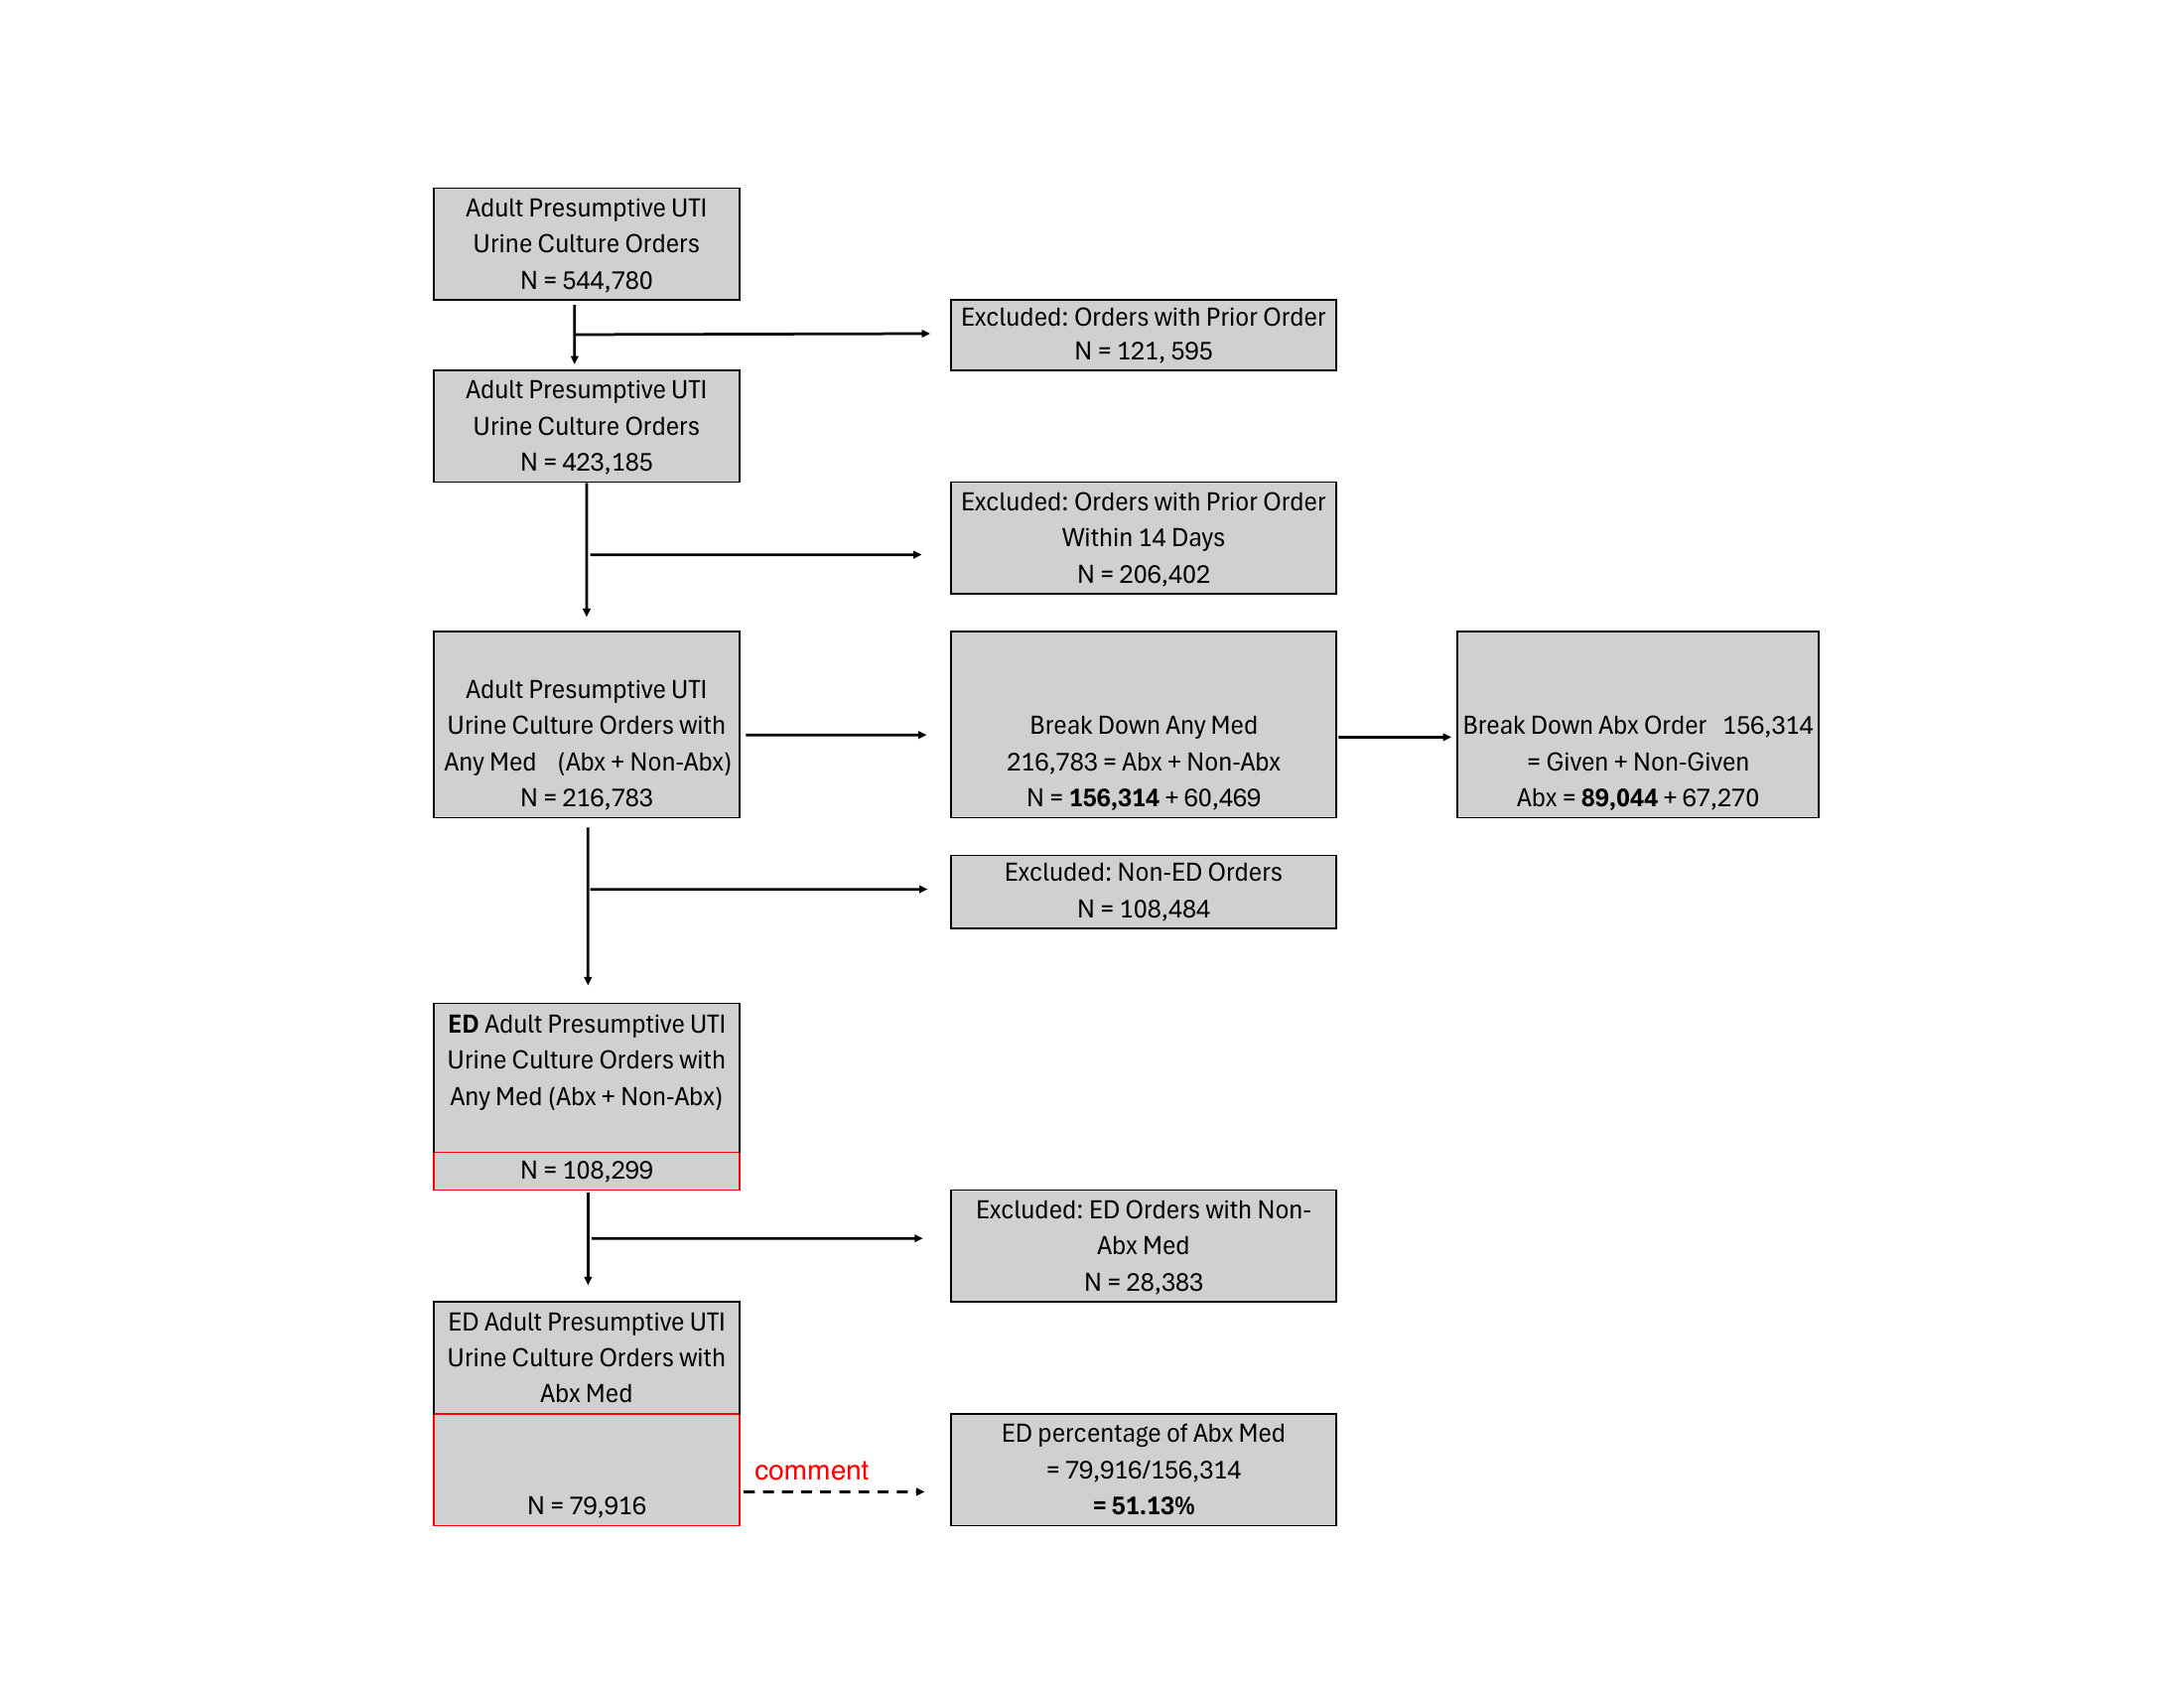

In [265]:
pages = convert_from_path('Notebook/imgs/Aim_4_Flowchart_Custom.pdf', dpi=200)
path_png = 'Notebook/imgs/step4-1.png.png'
pages[5].save(path_png, 'PNG')
# Display the image in the notebook
display(Image(filename=path_png))

# ---------------------------------**Step 4.2** ------------------------

In [174]:
ED_culture_order_with_abx_med_given = ED_culture_order_with_abx_med[ED_culture_order_with_abx_med["medication_action"] == "Given"]
ED_culture_order_with_abx_med_non_given = ED_culture_order_with_abx_med[ED_culture_order_with_abx_med["medication_action"]!= "Given"]
print("the unique order number for ED_culture_order_with_abx_med_given is {}".format(find_unique_orders(ED_culture_order_with_abx_med_given)))
print("the unique order number for ED_culture_order_with_abx_med_non_given is {}".format(find_unique_orders(ED_culture_order_with_abx_med) - find_unique_orders(ED_culture_order_with_abx_med_given)))

the unique order number for ED_culture_order_with_abx_med_given is 60008
the unique order number for ED_culture_order_with_abx_med_non_given is 19908


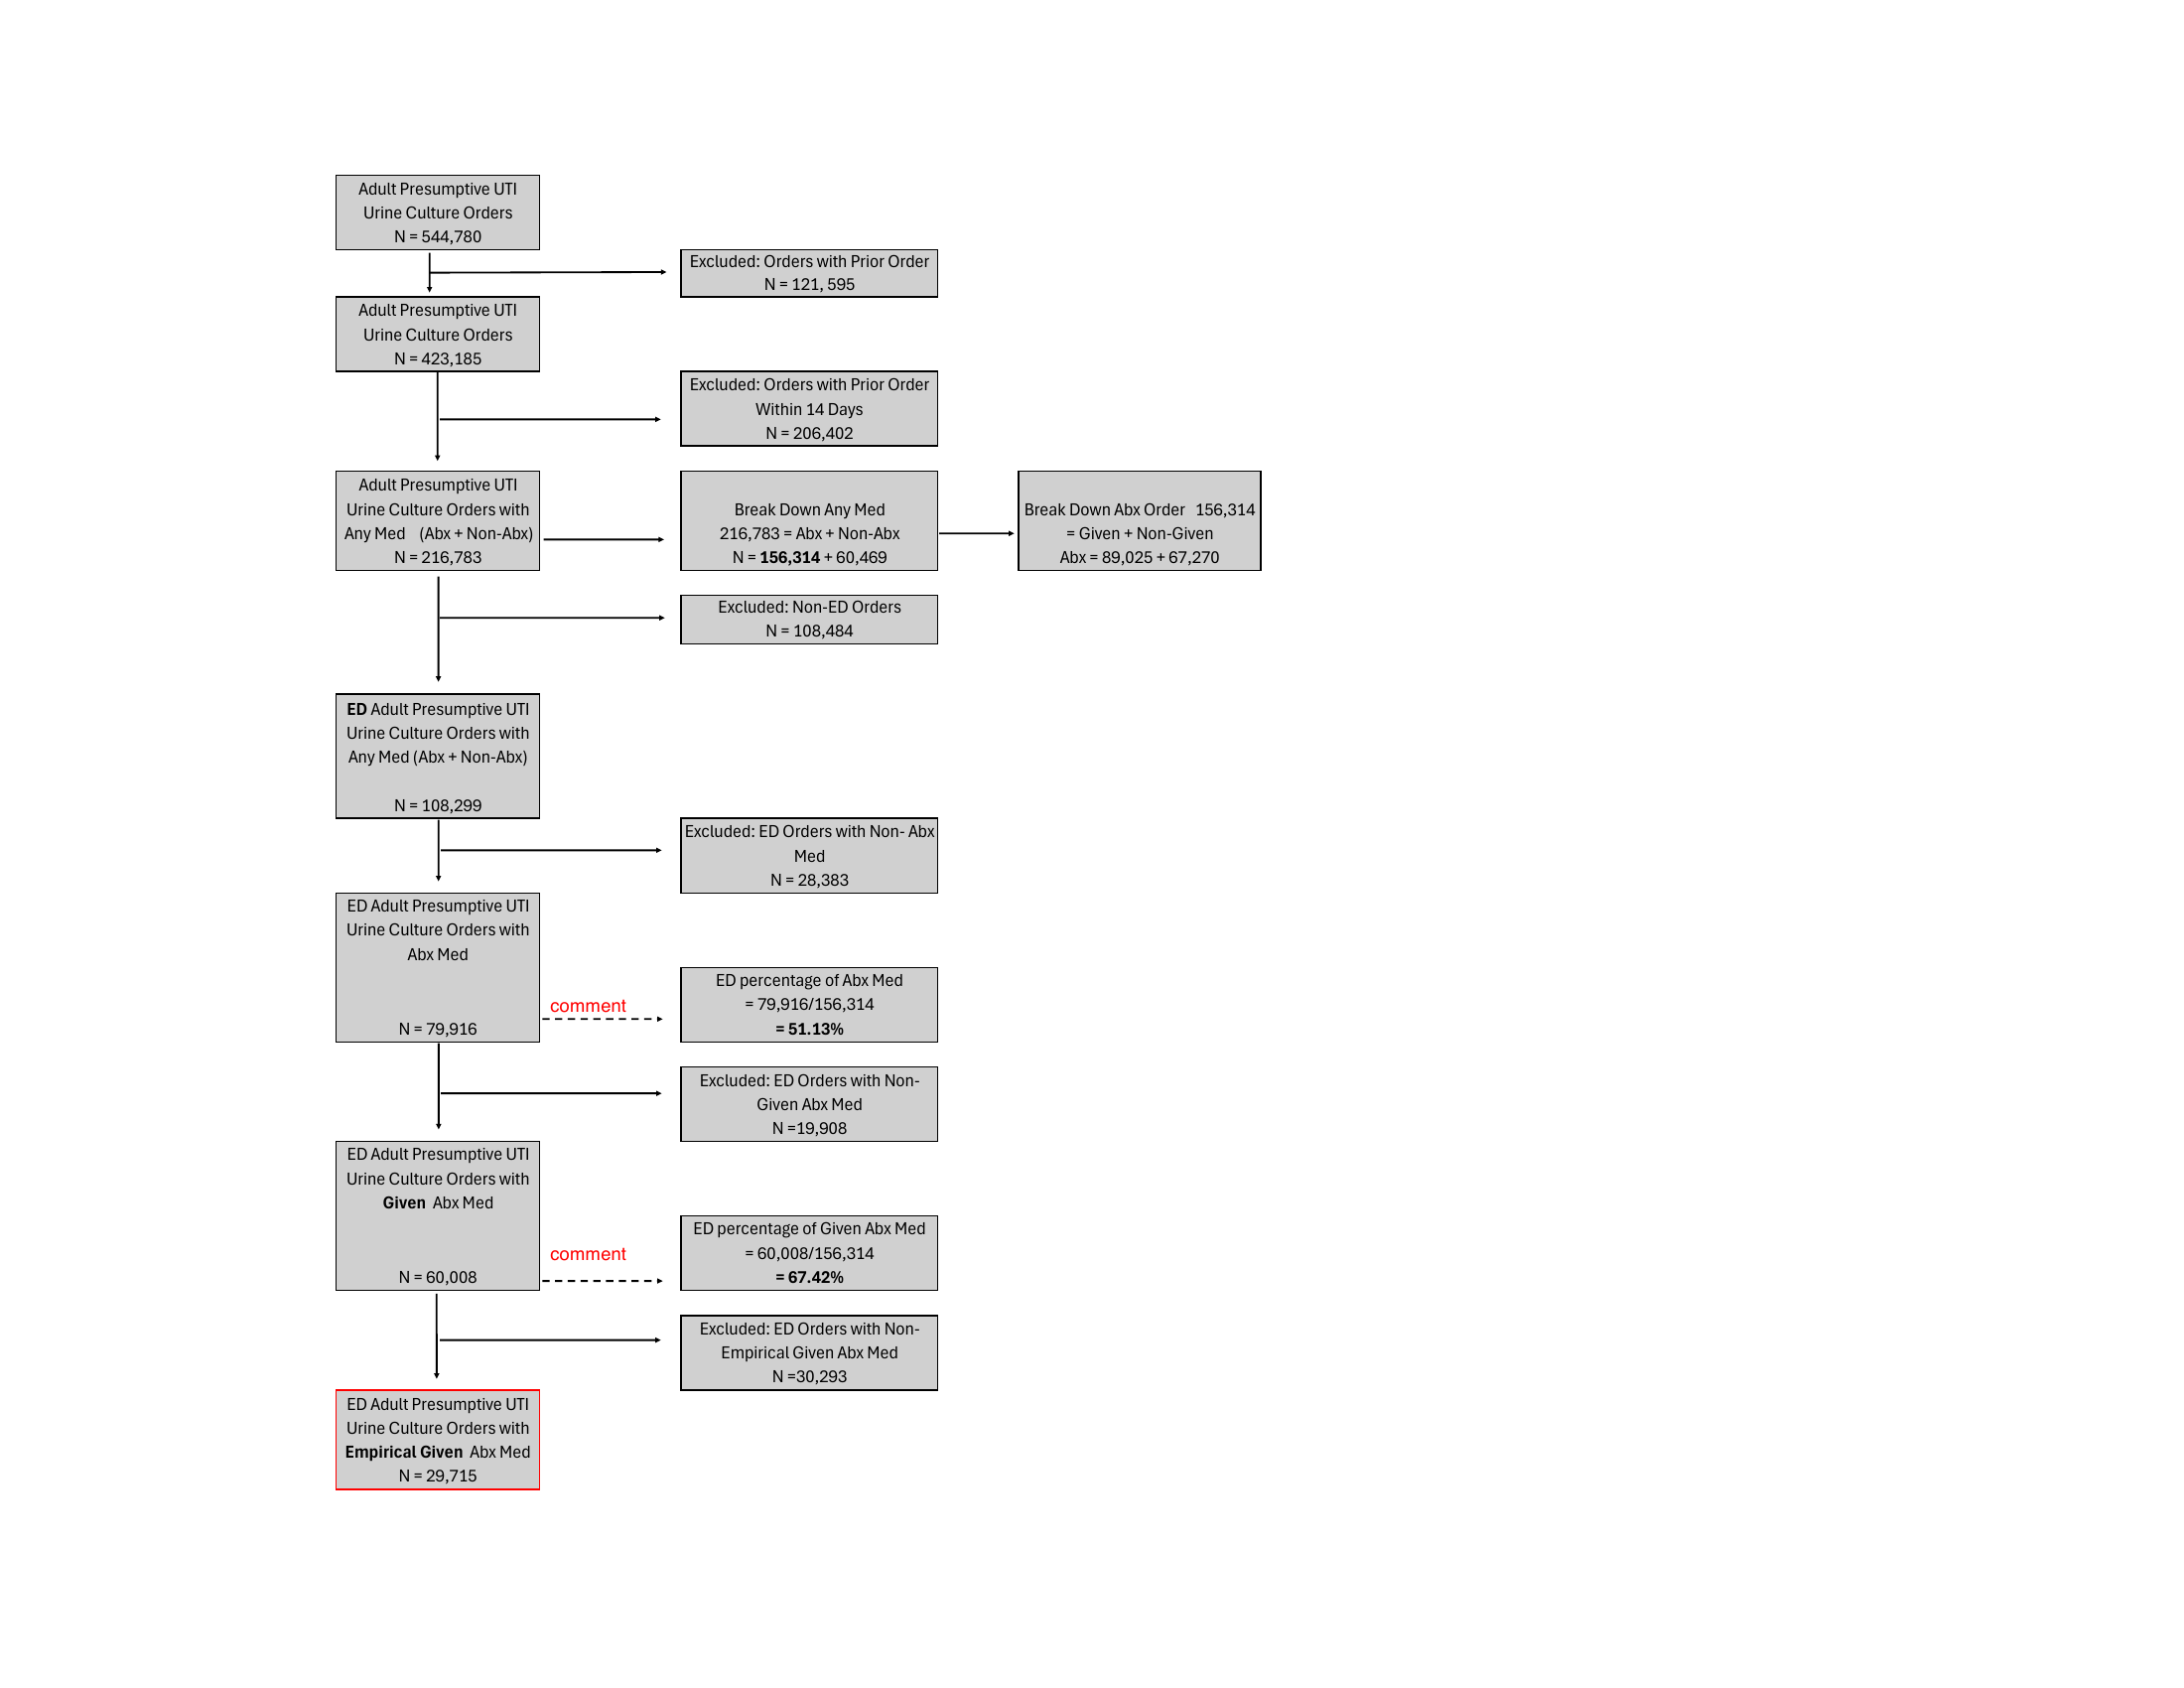

In [266]:
pages = convert_from_path('Notebook/imgs/Aim_4_Flowchart_Custom.pdf', dpi=200)
path_png = 'Notebook/imgs/step4-2.png.png'
pages[7].save(path_png, 'PNG')
# Display the image in the notebook
display(Image(filename=path_png))

# ------------------------------**Step 5** -----------------------

## 🔍 Identifying Empirical Antibiotic Use in the ED Cohort

Now that we've curated the **`ED_culture_order_with_abx_med_given`** cohort, the next step is to determine:

> **How many of the 60,008 orders with antibiotic medications are empirical?**

### 📖 Definition of Empirical Use:
An antibiotic is considered **empirical** if either of the following conditions is met:

1. **The medication time** is **after the culture order time** but **before the culture result time**.
2. **The medication time** is **within 6 hours before** the culture order time.

This definition helps us identify antibiotics that were likely prescribed based on **clinical suspicion**, prior to definitive diagnostic results.

In [179]:
ED_culture_order_with_abx_med_given = ED_culture_order_with_abx_med_given.drop(columns=['hosp_ward_IP', 'hosp_ward_OP', 'hosp_ward_ER', 'hosp_ward_ICU'])

In [ ]:
ED_culture_order_with_abx_med_given

In [181]:
# Group by the specified columns
grouped = ED_culture_order_with_abx_med_given.groupby(['anon_id', 'pat_enc_csn_id_coded', 'order_proc_id_coded', 'order_time_jittered_utc'])

# Function to filter each group
def filter_group(group):
        # Keep rows where:
        # 1. medication_time is greater than culture order time but smaller than result time, OR
        # 2. medication_time is within 6 hours before the culture order time
    condition = (
        ((group['medication_time'] > group['order_time_jittered_utc']) & 
            (group['medication_time'] < group['result_time_jittered_utc'])) | 
        ((group['medication_time'] >= (group['order_time_jittered_utc'] - pd.Timedelta(hours=6))) & 
            (group['medication_time'] <= group['order_time_jittered_utc'])
    ))
    return group[condition]

# Apply the filter to each group
filtered_groups = [filter_group(group) for _, group in grouped]

# Combine the filtered groups into a new DataFrame
filtered_df = pd.concat([group for group in filtered_groups if group is not None])

# Reset the index
# filtered_df = filtered_df.reset_index(drop=True)


In [ ]:
filtered_df

In [ ]:
# starting_cohort["order_time_jittered_utc"].dt.year.value_counts().sort_index()
# filtered_df["order_time_jittered_utc"].dt.year.value_counts().sort_index()
# # non_subset_rows = ED_culture_order_with_abx_med[~ED_culture_order_with_abx_med.index.isin(filtered_df.index)]
# non_subset_rows

In [187]:
filtered_df.to_csv('csv_folder/filtered_df.csv', index=False)
# will upload this to bigquery as well

In [186]:
print("the unique order number for empirical abx med order is {}".format(find_unique_orders(filtered_df)))
print("the unique order number for non empirical abx med order is {}"\
      .format(find_unique_orders(ED_culture_order_with_abx_med_given) -find_unique_orders(filtered_df)))

the unique order number for empirical abx med order is 29715
the unique order number for non empirical abx med order is 30293


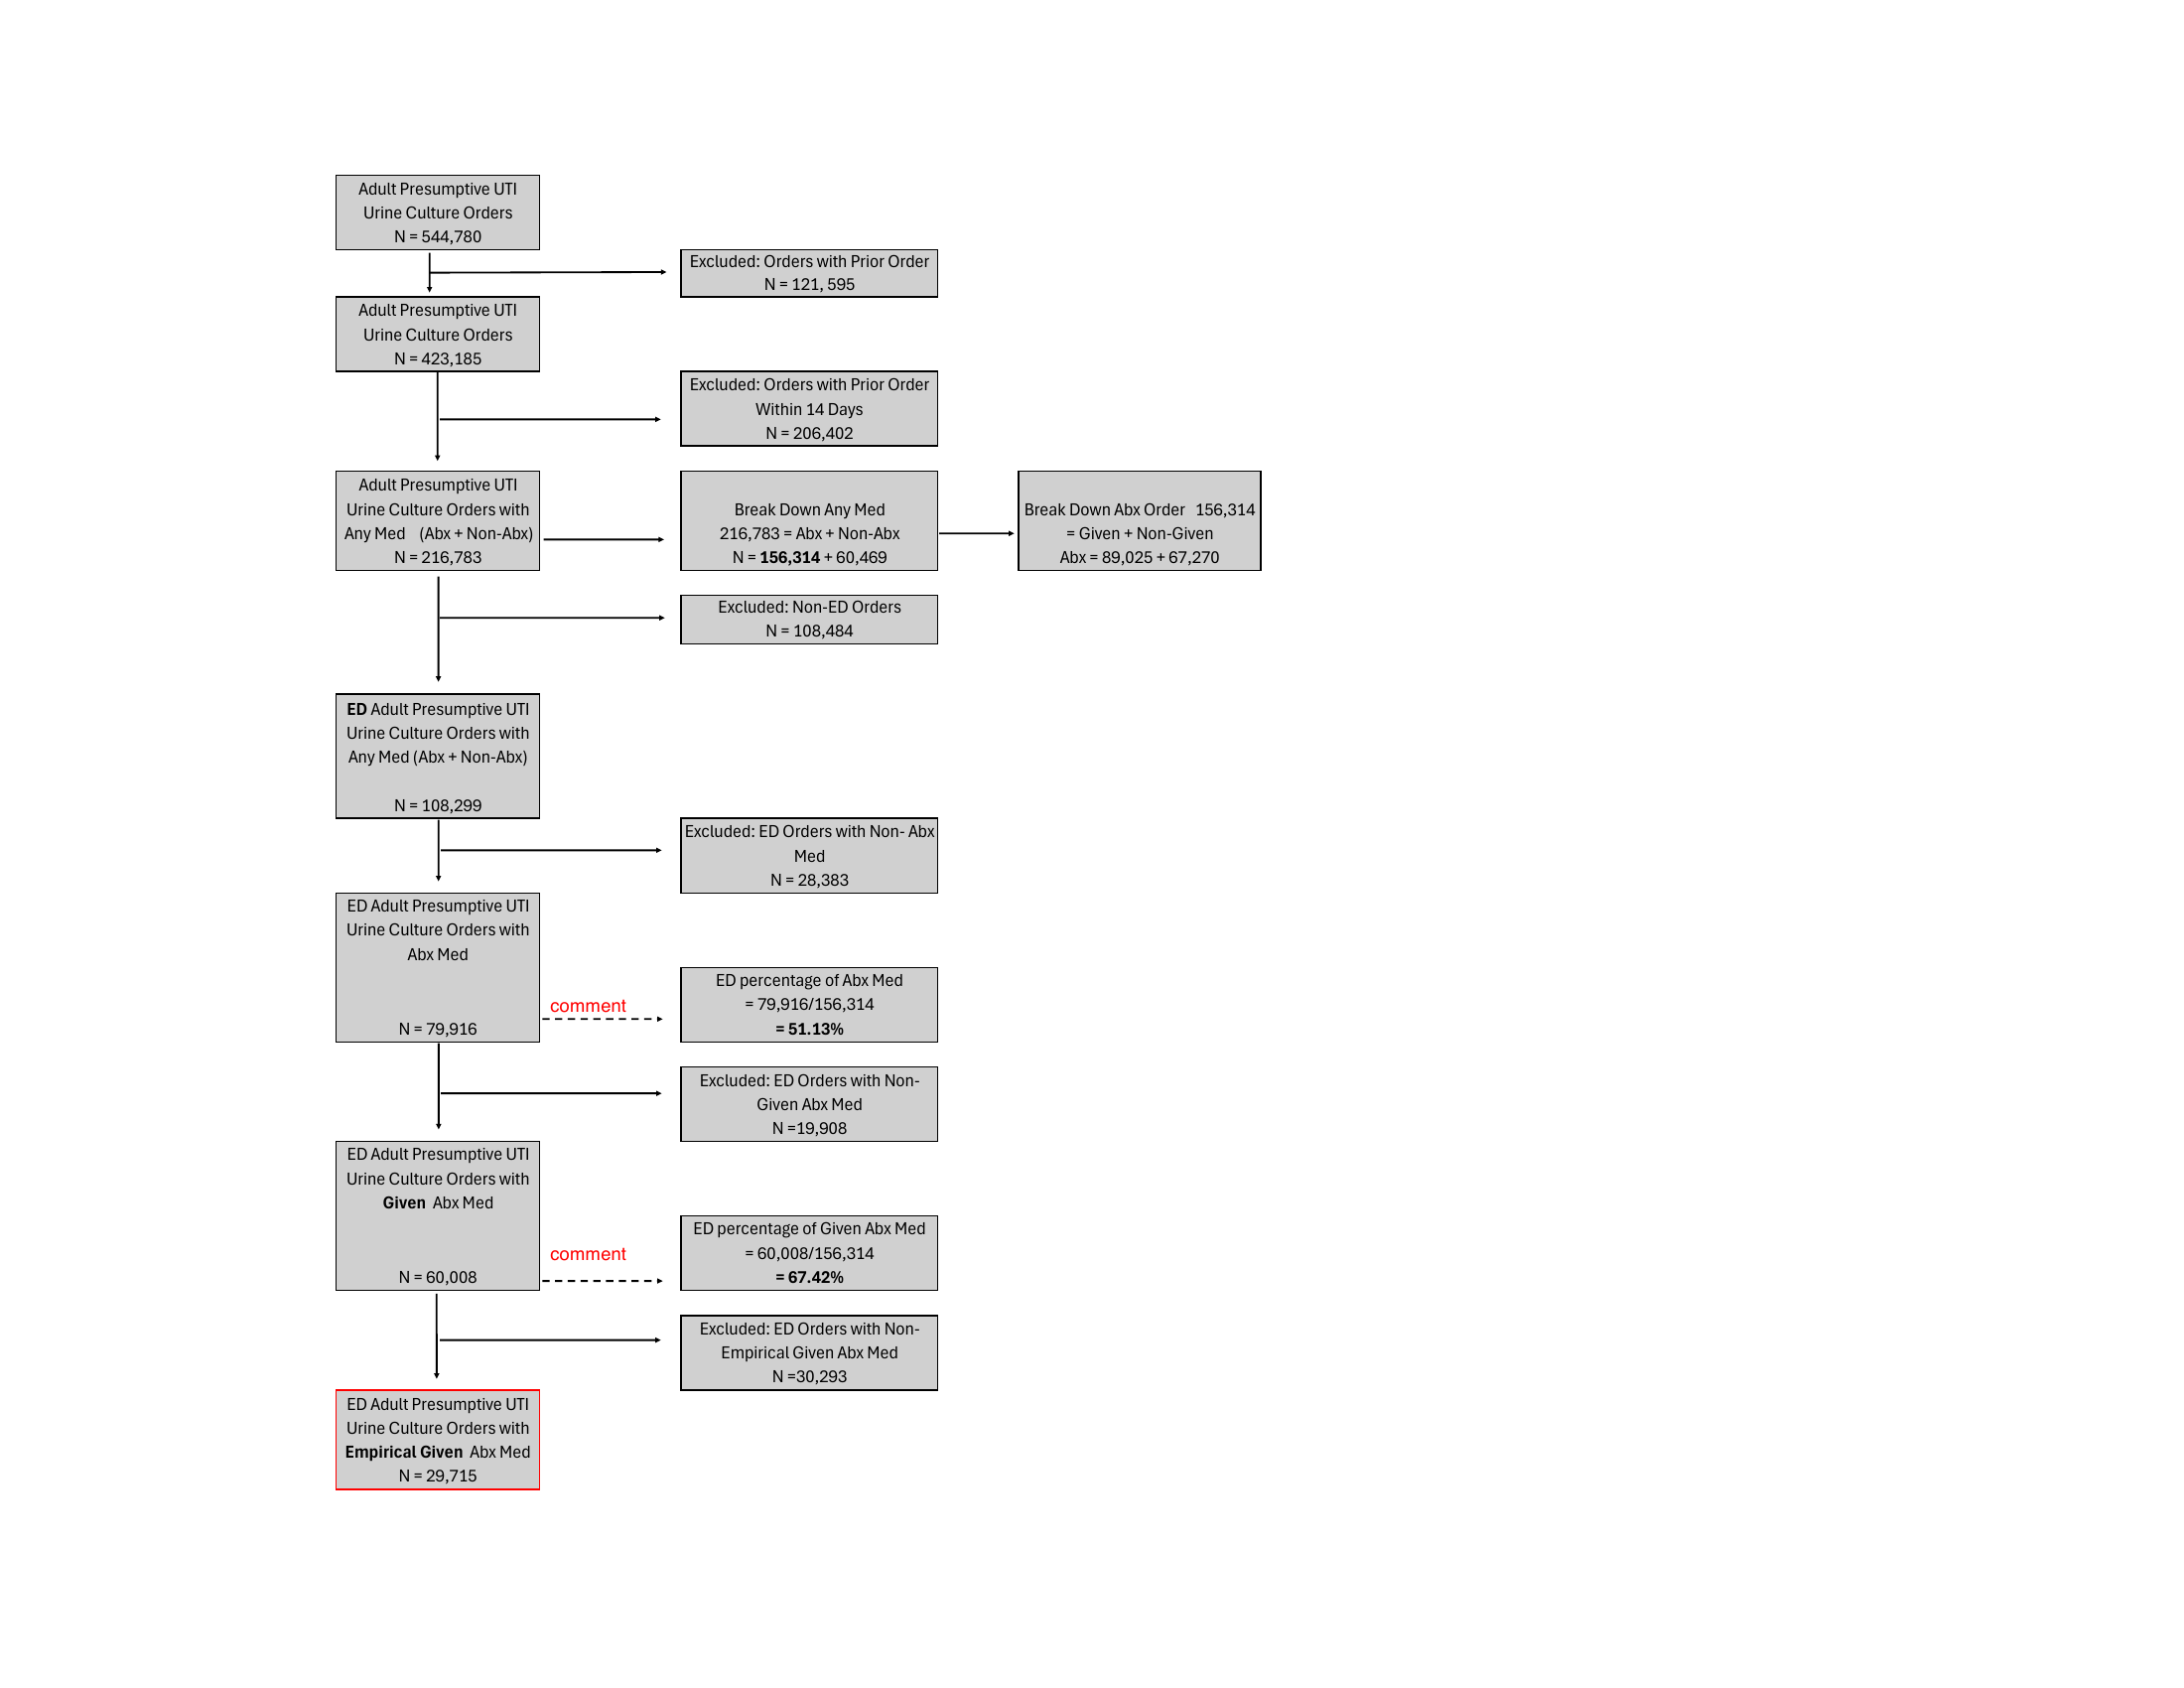

In [267]:
pages = convert_from_path('Notebook/imgs/Aim_4_Flowchart_Custom.pdf', dpi=200)
path_png = 'Notebook/imgs/step5.png.png'
pages[7].save(path_png, 'PNG')
# Display the image in the notebook
display(Image(filename=path_png))

# -----------------------------**Step 6** -------------------------------

## 🔍 Excluding Orders with Prior Medication Exposure

Now that we've identified the orders with **empirical antibiotic use**, the next step is to refine the cohort by accounting for **prior medication exposure**.

> We will exclude any orders where the patient received **any antibiotic within the 30 days** preceding the culture order.

This ensures that the empirical use we're measuring reflects **new treatments** rather than continued or repeated antibiotic use.

In [ ]:
%%bigquery --use_rest_api all_med
CREATE OR REPLACE TABLE `som-nero-phi-jonc101.antimicrobial_stewardship_sandy_refactor.all_med` AS 
WITH base_c AS (
    SELECT DISTINCT
        anon_id,
        pat_enc_csn_id_coded,
        order_proc_id_coded,
        order_time_jittered_utc,
        result_time_jittered_utc
    FROM 
        `som-nero-phi-jonc101.antimicrobial_stewardship_sandy_refactor.microbiology_urine_cultures_cohort`
        -- limit 1000
),
cleaned_medications AS (
    SELECT 
        c.anon_id,
        c.pat_enc_csn_id_coded,
        c.order_proc_id_coded,
        c.order_time_jittered_utc,
        c.result_time_jittered_utc,
        mo.ordering_date_jittered_utc AS medication_time,
        mo.med_description AS medication_name,
        mo.pat_enc_csn_id_coded AS medication_encounter_id,
        ARRAY_AGG(DISTINCT ca.antibiotic_name IGNORE NULLS) AS cleaned_antibiotic,
         -- Avoid nulls  -- Aggregates matche
        mar.order_med_id_coded,
        mar.mar_action AS medication_action
    FROM 
        base_c c
    LEFT JOIN 
        `som-nero-phi-jonc101.shc_core_2023.order_med` mo
        USING(anon_id)
    LEFT JOIN 
        `som-nero-phi-jonc101.antimicrobial_stewardship_sandy_refactor.clean_antibiotic` ca
        ON LOWER(mo.med_description) LIKE CONCAT('%', LOWER(ca.antibiotic_name), '%')  -- Match antibiotic names within medication_name
    LEFT JOIN 
        `som-nero-phi-jonc101.shc_core_2023.pharmacy_mar` mar # Incorportedated the pharmacy_mar table to get the medication action
        on mo.anon_id = mar.anon_id 
        and mo.order_med_id_coded = mar.order_med_id_coded
        and mo.pat_enc_csn_id_coded = mar.mar_enc_csn_coded
    GROUP BY 
        c.anon_id, c.pat_enc_csn_id_coded, c.order_proc_id_coded, 
        c.order_time_jittered_utc, c.result_time_jittered_utc, 
        mo.ordering_date_jittered_utc, mo.med_description, mo.pat_enc_csn_id_coded, mar.order_med_id_coded, mar.mar_action
    -- limit 1000
)

SELECT * 
FROM cleaned_medications
ORDER BY 
    anon_id, pat_enc_csn_id_coded, order_proc_id_coded, 
    order_time_jittered_utc, result_time_jittered_utc, 
    medication_time, medication_name, medication_encounter_id
    -- limit 1000;

In [191]:
%%bigquery --use_rest_api all_med_sample
select * from `som-nero-phi-jonc101.antimicrobial_stewardship_sandy_refactor.all_med` limit 100

Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
all_med_sample.head(10)

## ⏳ Filtering Out Cultures with Prior Antibiotic Exposure

The following code block filters out culture orders where there was **prior antibiotic exposure** within the time window of:

> **6 hours to 720 hours (30 days)** before the culture order time.

This step ensures that we exclude patients who may have already been on antibiotics leading up to the culture, helping to isolate truly **empirical use cases**.

In [193]:
%%bigquery --use_rest_api final_cohort

WITH exclusion AS (
    SELECT
      distinct
        anon_id,
        pat_enc_csn_id_coded,
        order_proc_id_coded,
        order_time_jittered_utc
    FROM
        `som-nero-phi-jonc101.antimicrobial_stewardship_sandy_refactor.all_med` al
    INNER JOIN 
        `som-nero-phi-jonc101.antimicrobial_stewardship_sandy_refactor.step_5_filtered_df` m
    USING
        (anon_id, pat_enc_csn_id_coded, order_proc_id_coded, order_time_jittered_utc)
    WHERE
    al.medication_time IS NOT NULL
    AND ARRAY_LENGTH(al.cleaned_antibiotic) > 0 
    AND al.medication_action like "Given"
    AND TIMESTAMP_DIFF(al.medication_time, al.order_time_jittered_utc, HOUR) > -720
    AND TIMESTAMP_DIFF(al.medication_time, al.order_time_jittered_utc, HOUR) < -6
),

filtered_groups AS (
    SELECT
        m.*
    FROM
         `som-nero-phi-jonc101.antimicrobial_stewardship_sandy_refactor.step_5_filtered_df` m
    WHERE
        -- Disregard groups where any medication_time is between 6 and 720 hours after order_time_jittered_utc
        NOT EXISTS (
            SELECT 1
            FROM exclusion ex
            WHERE
                ex.anon_id = m.anon_id
                AND ex.pat_enc_csn_id_coded = m.pat_enc_csn_id_coded
                AND ex.order_proc_id_coded = m.order_proc_id_coded
                AND ex.order_time_jittered_utc = m.order_time_jittered_utc
        )
)
SELECT 
*
    -- distinct
    -- anon_id,
    -- pat_enc_csn_id_coded,
    -- order_proc_id_coded,
    -- order_time_jittered_utc
    -- -- medication_time,
    -- -- result_time_jittered_utc
    -- -- medication_name,

FROM
    filtered_groups
ORDER BY
    anon_id,
    pat_enc_csn_id_coded,
    order_proc_id_coded,
    order_time_jittered_utc

Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
final_cohort

In [ ]:
# This also brings up another problem: how do we actually want to evaluate appropriteness of medication prescription for one culture order.
# Nick could talk more about this
# Count number of rows per group
group_counts = final_cohort.groupby(
    ['anon_id', 'pat_enc_csn_id_coded', 'order_proc_id_coded', 'order_time_jittered_utc']
)['cleaned_antibiotic'].transform('count')

# Filter rows where group count is greater than 1
group_counts_df= final_cohort[group_counts > 1]
sorted_group_counts_df = group_counts_df.sort_values(by=['anon_id', 'pat_enc_csn_id_coded', 'order_proc_id_coded', 'order_time_jittered_utc'])
# sorted_group_counts_df.head(50)
sorted_group_counts_df

In [199]:
print("the unique order number for final_cohort is {}".format(find_unique_orders(final_cohort)))
print("the unique order number from final cohort that has more than one medication is {}".format(find_unique_orders(sorted_group_counts_df)))

the unique order number for final_cohort is 13146
the unique order number from final cohort that has more than one medication is 4606


Before cleaning up the medication name: out of the 13,146 valid unique culture orders, **4,606** were associated with **more than 1 medications**.

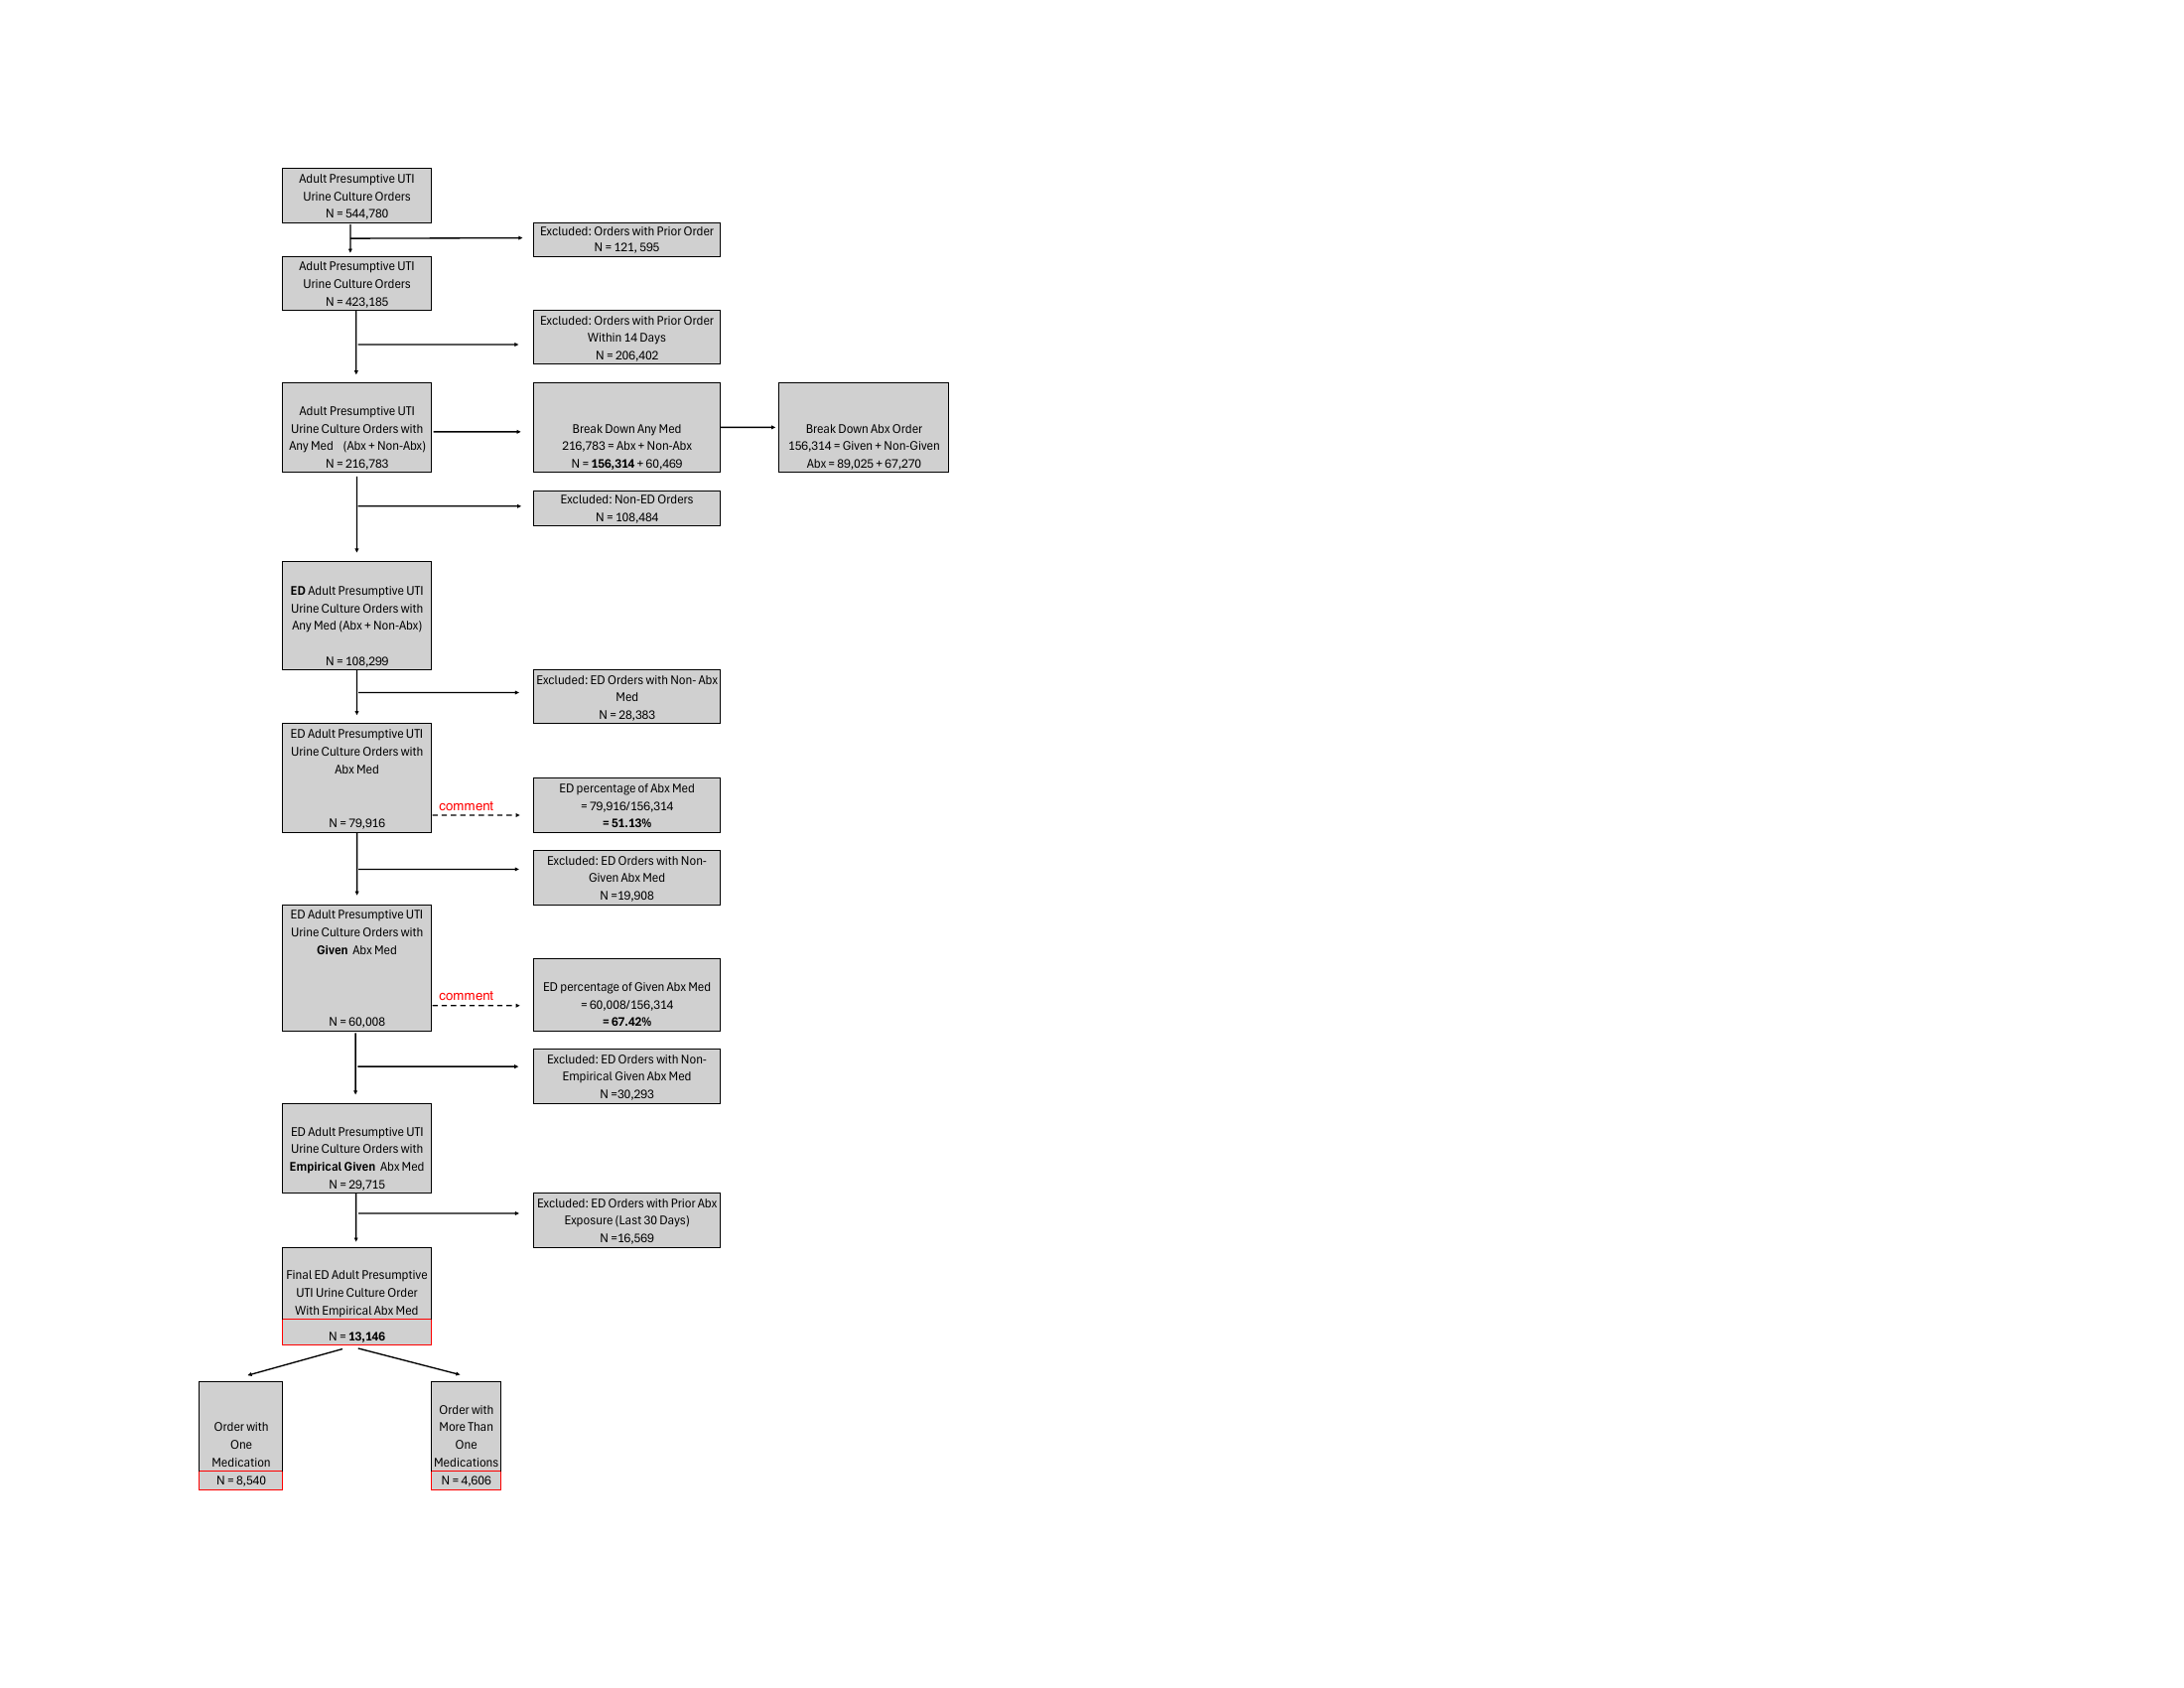

In [268]:
pages = convert_from_path('Notebook/imgs/Aim_4_Flowchart_Custom.pdf', dpi=200)
path_png = 'Notebook/imgs/step6.png.png'
pages[8].save(path_png, 'PNG')
# Display the image in the notebook
display(Image(filename=path_png))